In [1]:
'''
variable parameters :
actor_lr = [0.0001,0.0003,0.0006,0.0009]
critic_lr = [0.001,0.003,0.009,0.0001,0.0003,0.0006,0.0009]
gamma = [0.9,0.99]
b_s = [16,32,128]'''
# this code isn't completelt commented since its a copy of main submission. AIm here is to just show Hyperparameter reults

# At some places, to show  how debugging was done, debugging part of the code is kept commented(not removed)

'\nvariable parameters :\nactor_lr = [0.0001,0.0003,0.0006,0.0009]\ncritic_lr = [0.001,0.003,0.009,0.0001,0.0003,0.0006,0.0009]\ngamma = [0.9,0.99]\nb_s = [16,32,128]'

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
# import torch # pytorch was not part of the lecture, but is of course permitted
import gym_electric_motor as gem
import gym
from gym.spaces import Box, Tuple
import sklearn
import random
import time
import copy
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D
from collections import deque

In [3]:
#### WRAPPER CLASS ####

class TranformObservationWrapper(gym.core.Wrapper):
    """
    As we only want to focus the specific case of current control, we will define this wrapper in order to select only the 
    states that are of importance for our task.
    """
    
    def __init__(self, environment):
        super().__init__(environment)
        self.observation_space = Box(
            self.env.limits[5] * np.concatenate((environment.observation_space[0].low[5:7], environment.observation_space[1].low)),
            self.env.limits[5] * np.concatenate((environment.observation_space[0].high[5:7], environment.observation_space[1].high)),
            dtype=np.float32
        )
        self.action_space = Box(
            self.env.limits[7] * environment.action_space.low,
            self.env.limits[7] * environment.action_space.high,
            dtype=np.float32
        )

    def step(self, action):
        action = np.clip(action, -self.env.limits[7], self.env.limits[7])
        action = action.copy() / self.env.limits[7]
        (state, ref), rew, term, info = self.env.step(action)
        observation = np.concatenate((state[5:7], ref))
        observation *= self.env.physical_system.limits[5]

        return observation, rew, term, info

    def reset(self, **kwargs):
        state, ref = self.env.reset()
        observation = np.concatenate((state[5:7], ref))
        observation *= self.env.physical_system.limits[5]
        
        return observation
    
    
#### ENVIRONMENT DEFINITION ####

motor_parameter = dict(p=3,            # [p]     = 1, number of pole pairs
                       r_s=18e-3,      # [r_s]   = Ohm, stator resistance
                       l_d=0.37e-3,    # [l_d]   = H, d-axis inductance
                       l_q=1.2e-3,     # [l_q]   = H, q-axis inductance
                       psi_p=65.65e-3, # [psi_p] = Vs, magnetic flux of the permanent magnet
                      )  
u_sup = 350

nominal_values=dict(omega=4000*2*np.pi/60,
                  i=230,
                  u=u_sup
                  )

limit_values=nominal_values.copy()

q_generator = gem.reference_generators.WienerProcessReferenceGenerator(reference_state='i_sq')
d_generator = gem.reference_generators.WienerProcessReferenceGenerator(reference_state='i_sd')
rg = gem.reference_generators.MultipleReferenceGenerator([q_generator, d_generator])

env = gem.make(# define a PMSM with continuous action space
               "PMSMCont-v1",
    
               # parameterize the PMSM
               motor_parameter=motor_parameter,
    
               # update the limitations of the state space
               limit_values=limit_values,
               nominal_values=nominal_values,
               
               # define the DC link voltage
               u_sup=u_sup, 
               
               # define the speed at which the motor is operated
               load=gem.physical_systems.ConstantSpeedLoad(omega_fixed=1000 * np.pi / 30), 
               
               # define the duration of one sampling step
               tau=100e-6, 
               
               # turn off terminations via limit violation and parameterize the reward function
               reward_function=gem.reward_functions.WeightedSumOfErrors(observed_states=None, 
                                                                        reward_weights={'i_sq': 1, 'i_sd': 1},
                                                                        reward_power=2
                                                                       ),
               # define the reference generator
               reference_generator=rg,
    
               # define a numerical solver of adequate accuracy
               ode_solver='scipy.solve_ivp',
    
               # sets the input space to be field oriented voltage
               control_space='dq', 
              )

# wrap the environment to filter out uninteresting states
env = TranformObservationWrapper(env)
env.reset();

# A warning could come up stating "UserWarning: WARN: Box bound precision lowered by casting to float32"
# This warning is harmless and can be ignored

c:\python 3.7\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


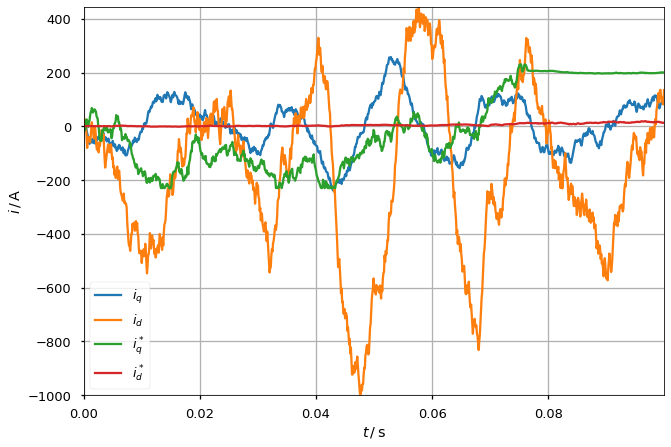

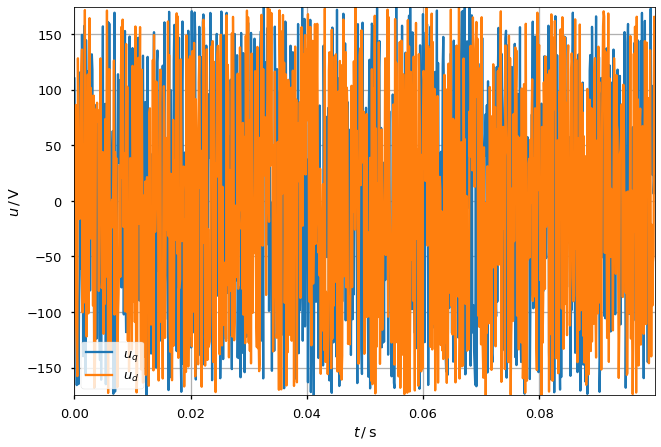

In [4]:
x = env.reset()
tau = env.env._physical_system.tau

simulation_time = 0.1 # seconds
nb_steps = int(simulation_time // tau)

X = []
U = []
T = []
t = 0
for i in tqdm(range(nb_steps)): 
    action = env.action_space.sample()
    X.append(x)
    U.append(action)
    T.append(t)
    x, reward, done, _ = env.step(action)
    
    t = t + tau
    
X = np.reshape(X, (-1, len(x)))
U = np.reshape(U, (-1, len(action)))

plt.plot(T, X[:, 0], label=r"$i_q$")
plt.plot(T, X[:, 1], label=r"$i_d$")
plt.plot(T, X[:, 2], label=r"$i_q^*$")
plt.plot(T, X[:, 3], label=r"$i_d^*$")
plt.xlabel(r'$t \, / \, \mathrm{s}$')
plt.ylabel(r'$i \, / \, \mathrm{A}$')
plt.autoscale(tight=True)
plt.legend()
plt.grid(True)
plt.show()

plt.plot(T, U[:, 0], label=r"$u_q$")
plt.plot(T, U[:, 1], label=r"$u_d$")
plt.xlabel(r'$t \, / \, \mathrm{s}$')
plt.ylabel(r'$u \, / \, \mathrm{V}$')
plt.autoscale(tight=True)
plt.legend()
plt.grid(True)
plt.show()

In [5]:
# x = env.reset()
# tau = env.env._physical_system.tau

# simulation_time = 0.1 # seconds
# nb_steps = int(simulation_time // tau)

# X = []
# U = []
# T = []
# t = 0
# for i in tqdm(range(nb_steps)): 
#     action = agent.actor.predict(np.array([x]))[0]
#     X.append(x)
#     U.append(action)
#     T.append(t)
#     x, reward, done, _ = env.step(action)
    
#     t = t + tau
    
# X = np.reshape(X, (-1, len(x)))
# U = np.reshape(U, (-1, len(action)))

# plt.plot(T, X[:, 0], label=r"$i_q$")
# plt.plot(T, X[:, 1], label=r"$i_d$")
# plt.plot(T, X[:, 2], label=r"$i_q^*$")
# plt.plot(T, X[:, 3], label=r"$i_d^*$")
# plt.xlabel(r'$t \, / \, \mathrm{s}$')
# plt.ylabel(r'$i \, / \, \mathrm{A}$')
# plt.autoscale(tight=True)
# plt.legend()
# plt.grid(True)
# plt.show()

# plt.plot(T, U[:, 0], label=r"$u_q$")
# plt.plot(T, U[:, 1], label=r"$u_d$")
# plt.xlabel(r'$t \, / \, \mathrm{s}$')
# plt.ylabel(r'$u \, / \, \mathrm{V}$')
# plt.autoscale(tight=True)
# plt.legend()
# plt.grid(True)
# plt.show()

In [6]:
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Flatten, Concatenate
from keras.optimizers import Adam
import keras.backend as K
from gym.wrappers import FlattenObservation
from keras.layers.merge import Add
from tensorflow.keras import initializers, regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2

In [7]:
class Exploration_noise:
    def __init__(self, mu, std_deviation, theta=0.15, dt=0.01, x_initial=None):
        self.theta = theta
        self.mu = mu
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape))
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mu)

In [8]:
class DDPGAgent:
    def __init__(self,environment,actor_lr,critic_lr):
        self.env = environment
        self.memory  = deque(maxlen=250000)
        self.gamma = 0.99
        self.actor_learning_rate = actor_lr
        self.critic_learning_rate = critic_lr
        self.batch_size = 96
        self.exploration_decay = 0.99995
        self.tau = self.env.env.physical_system.tau
        #dummy = self.env.reset()
        self.upper_bound = self.env.action_space.high
        self.lower_bound = self.env.action_space.low
        #print(self.upper_bound)
        
        self.actor = self.set_actor_model()
        self.target_actor = self.set_actor_model()
        self.target_actor.set_weights(self.actor.get_weights())
        
        self.critic = self.set_critic_model()
        self.target_critic = self.set_critic_model()
        self.target_critic.set_weights(self.critic.get_weights())
        
        self.critic_optimizer = tf.keras.optimizers.Adam(self.critic_learning_rate)
        self.actor_optimizer = tf.keras.optimizers.Adam(self.actor_learning_rate)
    
    def set_actor_model(self):
        #temp
        #state_input = Input(shape=self.env.observation_space.shape)
        actor = Sequential()
        actor.add(Flatten(input_shape=(1,) +self.env.observation_space.shape))
        #actor.add(Dense(32, activation = 'relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        #actor.add(tf.keras.initializers.RandomUniform(minval=-0.003, maxval=0.003))
        actor.add(Dense(16, activation = 'relu'))
        actor.add(Dense(17, activation = 'relu'))
        #actor.add(Dense(256, activation = 'relu'))
        #actor.add(Dense(256, activation = 'relu'))
        actor.add(Dense(self.env.action_space.shape[0],kernel_initializer=tf.random_uniform_initializer(minval=-0.003, maxval=0.003),
                        activation='tanh',bias_initializer = tf.random_uniform_initializer(minval=-0.0003, maxval=0.0003),
                       kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
        actor.add(tf.keras.layers.Lambda(lambda x: x * 175)) # new output layer
        #actor.compile(loss='mse',optimizer=Adam(lr=self.actor_learning_rate))
        #print(actor.summary())
        return actor
    
    def set_critic_model(self):
        # critic takes state,action as input and predicts vaue function
        action_input = Input(shape=(self.env.action_space.shape[0]))
        #action_1_layer = Dense(16, activation="relu",kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(action_input)
        
        observation_input = Input(shape=(1,) + self.env.observation_space.shape)
        #state_1 = Dense(32, activation="relu")(observation_input)
        #state_2 = Dense(16, activation="relu")(state_1)
        flattened_observation = Flatten()(observation_input)
        x = Concatenate()([flattened_observation,action_input])
        x = Dense(32, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        #x = Dense(400, activation='relu')(x)
        #x = Dense(300, activation='relu')(x)
        out = Dense(1, activation='linear')(x)
        critic = Model(inputs=(action_input, observation_input), outputs=out)  
        return critic
    
    def delibrate(self, obs):
        if self.update < self.batch_size:
            return
        if self.update < 5000:
             return
        samples = random.sample(self.memory, self.batch_size)
        
        cur_state_list=[]
        action_list=[]
        reward_list=[]
        next_state_list=[]
        for i in range(len(samples)):
            current_state, action, reward, next_state, done = samples[i]
            cur_state_list.append(current_state)
            action_list.append(action)
            reward_list.append([reward])
            next_state_list.append(next_state)
            
        reward_array= np.array(reward_list)
        next_state_array = np.array(next_state_list)
        action_array = np.array(action_list)
        current_state_array = np.array(cur_state_list)
        
        if not done:
            with tf.GradientTape() as tape:
                target_action_array = self.target_actor(next_state_array)
                y = reward_array + self.gamma * self.target_critic([target_action_array,next_state_array])
                critic_value = self.critic([action_array,current_state_array])
                critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))
                #print(critic_loss) 
                self.c_loss.append(critic_loss)
            critic_gradients = tape.gradient(critic_loss,self.critic.trainable_variables)
            self.critic_optimizer.apply_gradients(zip(critic_gradients,self.critic.trainable_variables))
            
        if not done:
            with tf.GradientTape() as tape:
                action = self.actor(current_state_array)
                critic_val = self.critic([action,current_state_array])
                actor_loss = tf.math.reduce_mean(-critic_val)
                #print(actor_loss)
                self.ac_loss.append(actor_loss)
            actor_gradients = tape.gradient(actor_loss,self.actor.trainable_variables)
            self.actor_optimizer.apply_gradients(zip(actor_gradients,self.actor.trainable_variables))
            
            # uncomment while debugging 
#         if self.update % 200 == 0:
#             print("critic loss is " + str(critic_loss) + ' actor loss is '+ str(actor_loss))
            #print(((self.target_actor.weights[0].numpy()) == (self.actor.weights[0].numpy())).all())
    
        
            
    @tf.function
    def update_target(self,target_weights, weights ,tau=0.001):
        for (a, b) in zip(target_weights, weights):
            a.assign(b * tau + a * (1 - tau))
        
    def decide(self,state,std_dev):
        ou_noise = Exploration_noise(mu=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
        action_samples = tf.squeeze(self.actor.predict(np.array([state]))[0])
        noise = ou_noise()
        action_samples = action_samples.numpy()
        action_samples += noise *0.1*175
        # action is in [-175, 175]
        a = np.clip(action_samples, -175, 175)
        return a, noise*175
    
    
    
    def memory_update(self,current_state,action , reward, next_state, done):
        self.memory.append((current_state,action , reward, next_state, done))
        
    def train(self,visualise=False):
        simulation_time = 10 # seconds
        nb_steps =int(simulation_time // self.tau)
        max_episode_length = 5000
        nb_episodes = int(nb_steps//max_episode_length) +1
#         std_dev = 0.2
#         ou_noise = Exploration_noise(mu=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
        log = {'cum_rew': [],'critic_loss':[],'actor_loss':[]}
        std_dev = 0.3
        self.update = 0
        for i in tqdm(range(nb_episodes)):
            self.X=[]
            self.U = []
            self.T=[]
            exp=[]
            self.c_loss =[]
            self.ac_loss=[]
            k = 0
            t=0
            cum_rew = 0
            cur_state = self.env.reset()
            cur_state = cur_state.reshape((1, self.env.observation_space.shape[0]))
            done = False
            while not done:
                action,explore = self.decide(cur_state,std_dev)
                next_state, reward, done, _ = self.env.step(action)
                done = done or k == (max_episode_length - 1)  # force done after max_episodes
                next_state = next_state.reshape((1, self.env.observation_space.shape[0]))
                self.memory_update(cur_state,action,reward,next_state, done)
                self.delibrate(next_state)
                #self.X.append(cur_state[0])
                #self.U.append(action)
                #self.T.append(t)
                #exp.append(explore)
#                 if i == 0 and self.c_loss[k+self.batch_size]!= []:
#                     print(self.c_loss[k+self.batch_size])
                cur_state = next_state 
                self.update_target(self.target_actor.variables, self.actor.variables)
                self.update_target(self.target_critic.variables, self.critic.variables)
                t = t + self.tau
                self.update += 1
                k += 1
                cum_rew += reward
                if self.update < 60000:
                    std_dev = std_dev * self.exploration_decay
                    std_dev = max(std_dev,0.01)
                else:
                    std_dev = 0.01
            log['cum_rew'].append(cum_rew)
            log['critic_loss'].append(np.array(self.c_loss).mean())
            log['actor_loss'].append(np.array(self.ac_loss).mean())

            # use for debugging
            #self.X = np.reshape(self.X, (-1, len(cur_state[0])))
            #self.U = np.reshape(self.U, (-1, len(action)))
            #exp = np.array(exp)
            #print('action 0 max : '+ str(self.U[:, 0].max()) +' action 0 min : '+ str(self.U[:, 0].min()))
            #print('action 1 max : '+ str(self.U[:, 1].max()) +' action 1 min : '+ str(self.U[:, 1].min()))
#             if i!= 0:
#                 print('mean critic loss : ' + str(np.array(self.c_loss).mean()))
#                 print('mean actor loss : ' + str(np.array(self.ac_loss).mean()))
            #print('max and min additional noise per step is ' + str(exp.max()) + str(exp.min()))
            #print('mean additional noise per step is ' + str(exp.mean()))
            
            if visualise:
                plt.plot(self.T, self.X[:, 0], label=r"$i_q$")
                plt.plot(self.T, self.X[:, 1], label=r"$i_d$")
                plt.plot(self.T, self.X[:, 2], label=r"$i_q^*$")
                plt.plot(self.T, self.X[:, 3], label=r"$i_d^*$")
                plt.xlabel(r'$t \, / \, \mathrm{s}$')
                plt.ylabel(r'$i \, / \, \mathrm{A}$')
                plt.autoscale(tight=True)
                plt.legend()
                plt.grid(True)
                plt.show()

                plt.plot(self.T, self.U[:, 0], label=r"$u_q$")
                plt.plot(self.T, self.U[:, 1], label=r"$u_d$")
                plt.xlabel(r'$t \, / \, \mathrm{s}$')
                plt.ylabel(r'$u \, / \, \mathrm{V}$')
                plt.autoscale(tight=True)
                plt.legend()
                plt.grid(True)
                plt.show()
        return log
            
    def test(self,n_episodes=50, max_episode_len=1000, Visualise = True):
        log = {'cum_rew': []}
        for ep in tqdm(range(n_episodes)):
            X=[]
            U=[]
            T=[]
            state = self.env.reset()
            state = state.reshape((1, self.env.observation_space.shape[0]))
            k = 0
            cum_rew = 0
            done = False
            while not done:
                action = self.actor.predict(np.array([state]))[0]
                state, reward, done, _ = self.env.step(action)
                state = state.reshape((1, self.env.observation_space.shape[0]))
                done = done or k == (max_episode_len - 1)  # force done after max_episodes
                k+=1
                cum_rew += reward
            log['cum_rew'].append(cum_rew/k)
            #print(cum_rew)
        #print(f'tested for {ep+1} episodes')
        print('Mean is',np.array(log['cum_rew']).mean()),print('variance is' , np.array(log['cum_rew']).var())
        return log

In [9]:
def test(n_episodes=50, max_episode_len=1000, Visualise = True):
    log = {'cum_rew': []}
    for ep in tqdm(range(n_episodes)):
        X=[]
        U=[]
        T=[]
        state = agent.env.reset()
        state = state.reshape((1, agent.env.observation_space.shape[0]))
        k = 0
        t=0
        cum_rew = 0
        done = False
        while not done:
            action = agent.actor.predict(np.array([state]))[0]
            next_state, reward, done, _ = agent.env.step(action)
            next_state = next_state.reshape((1, agent.env.observation_space.shape[0]))
            done = done or k == (max_episode_len - 1)  # force done after max_episodes
            X.append(state)
            U.append(action)
            T.append(t)
            k+=1
            t = t + agent.tau
            cum_rew += reward
            state = next_state
        log['cum_rew'].append(cum_rew)
        #print(cum_rew)
        X = np.reshape(X, (-1, len(state[0])))
        U = np.reshape(U, (-1, len(action)))
        #print(X)
#         #print('mean action is ' + str(self.U.mean()))
#         plt.plot(T, X[:, 0], label=r"$i_q$")
#         plt.plot(T, X[:, 1], label=r"$i_d$")
#         plt.plot(T, X[:, 2], label=r"$i_q^*$")
#         plt.plot(T, X[:, 3], label=r"$i_d^*$")
#         plt.xlabel(r'$t \, / \, \mathrm{s}$')
#         plt.ylabel(r'$i \, / \, \mathrm{A}$')
#         plt.autoscale(tight=True)
#         plt.legend()
#         plt.grid(True)
#         plt.show()

#         plt.plot(T, U[:, 0], label=r"$u_q$")
#         plt.plot(T, U[:, 1], label=r"$u_d$")
#         plt.xlabel(r'$t \, / \, \mathrm{s}$')
#         plt.ylabel(r'$u \, / \, \mathrm{V}$')
#         plt.autoscale(tight=True)
#         plt.legend()
#         plt.grid(True)
#         plt.show()
    #print(f'tested for {ep+1} episodes')
    print('Mean is',np.array(log['cum_rew']).mean()),print('variance is' , np.array(log['cum_rew']).var())
    return log

In [10]:
# Grid search inputs
actor_lr_list = [0.0003,0.0007,0.00001,0.00005,0.00008,0.000002,0.000005,0.000008 ]
critic_lr_list = [0.001,0.003,0.005,0.007]

In [11]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')

Training for actor learning rate : 0.0003 critic learning rate : 0.001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


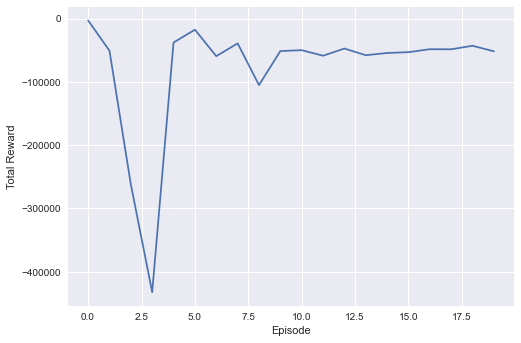


Mean is -10483.875245180869
variance is 1072033.5479815898


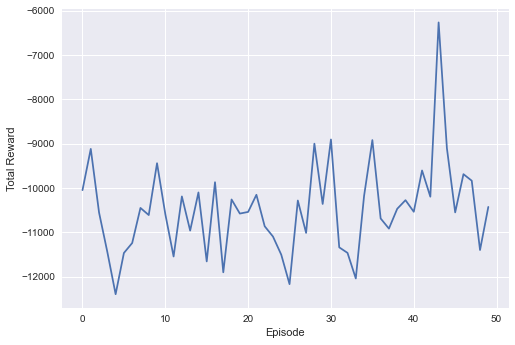

Training for actor learning rate : 0.0003 critic learning rate : 0.003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


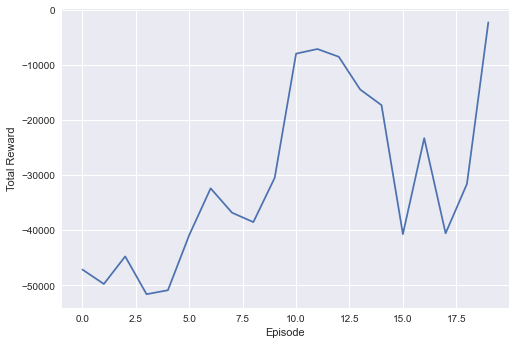


Mean is -1346.7852514233316
variance is 2219954.5767025524


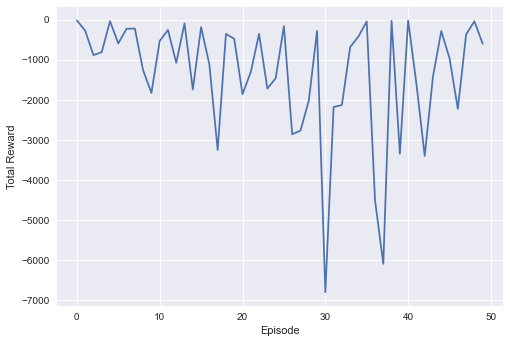

Training for actor learning rate : 0.0003 critic learning rate : 0.005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


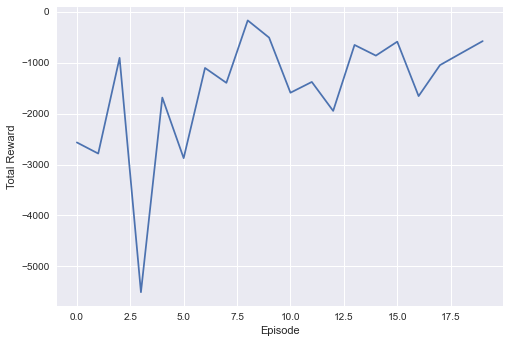


Mean is -84.31964522982024
variance is 11600.799348502544


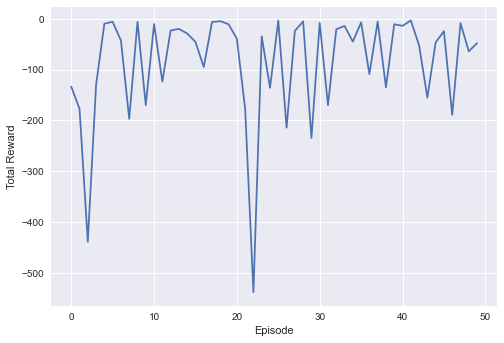

Training for actor learning rate : 0.0003 critic learning rate : 0.007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


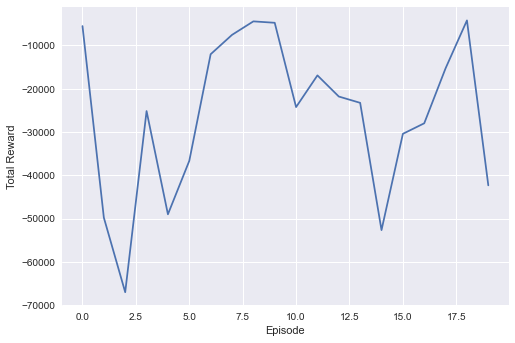


Mean is -5626.189787201774
variance is 19214715.943710167


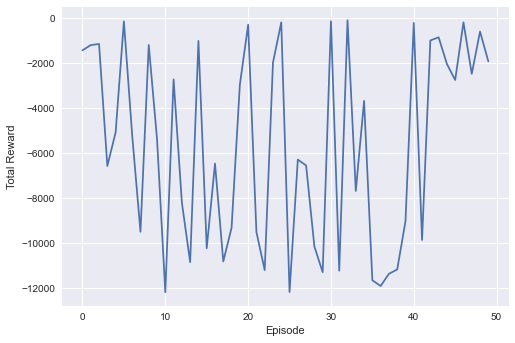

Training for actor learning rate : 0.0007 critic learning rate : 0.001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


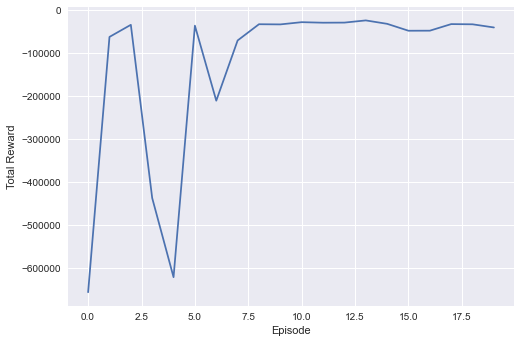


Mean is -7728.014167214145
variance is 1480515.9226076026


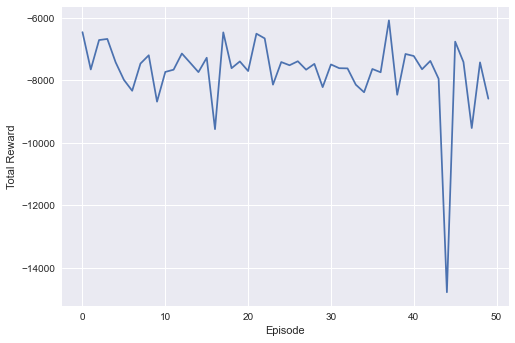

Training for actor learning rate : 0.0007 critic learning rate : 0.003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


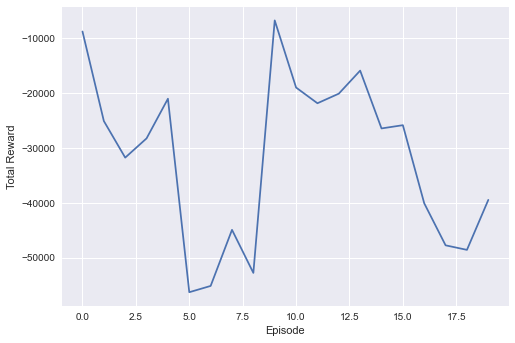


Mean is -7177.510713471045
variance is 4620677.0941014


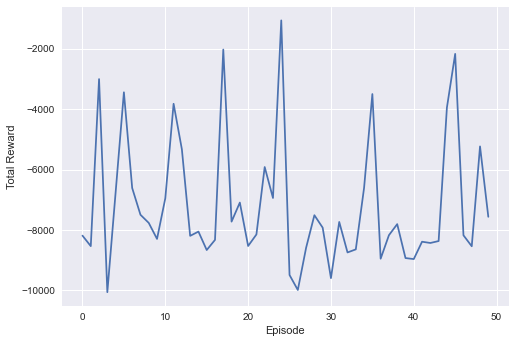

Training for actor learning rate : 0.0007 critic learning rate : 0.005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


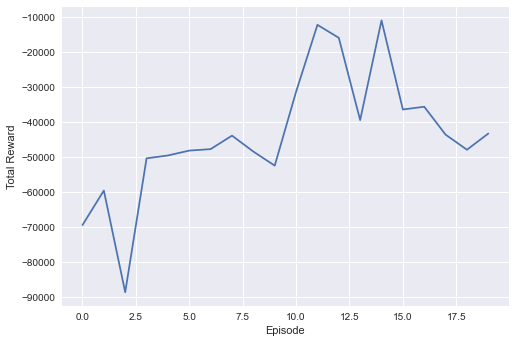


Mean is -9769.271268497148
variance is 747557.8192231298


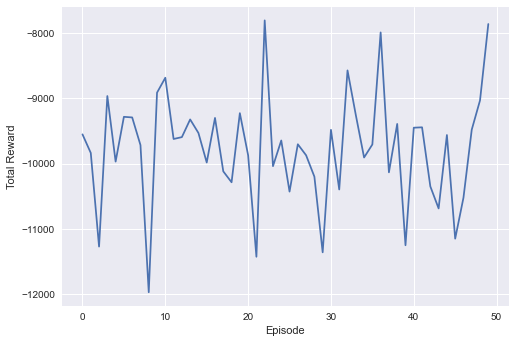

Training for actor learning rate : 0.0007 critic learning rate : 0.007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


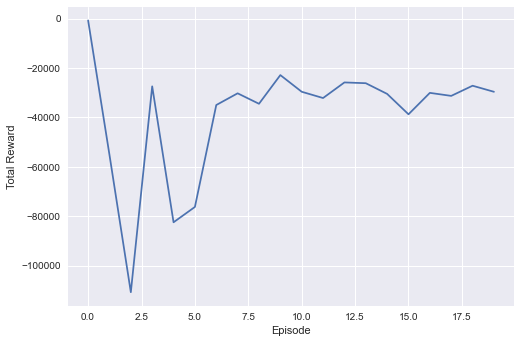


Mean is -5638.094307722532
variance is 313996.26152086264


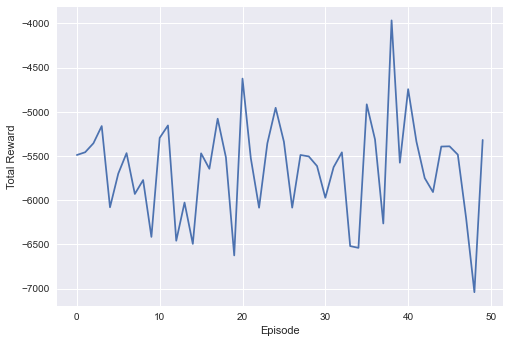

Training for actor learning rate : 1e-05 critic learning rate : 0.001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


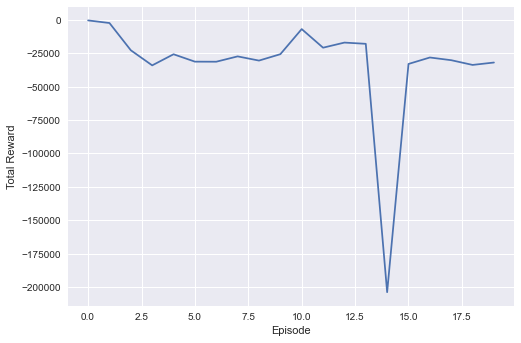


Mean is -6606.842944855614
variance is 334766.3804342432


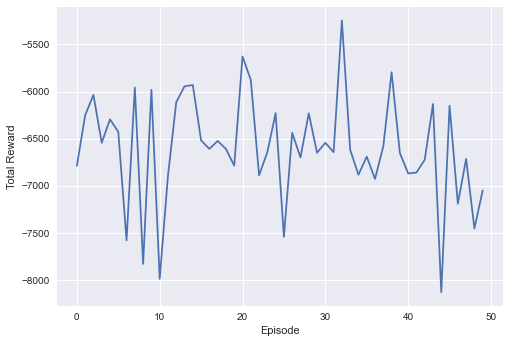

Training for actor learning rate : 1e-05 critic learning rate : 0.003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


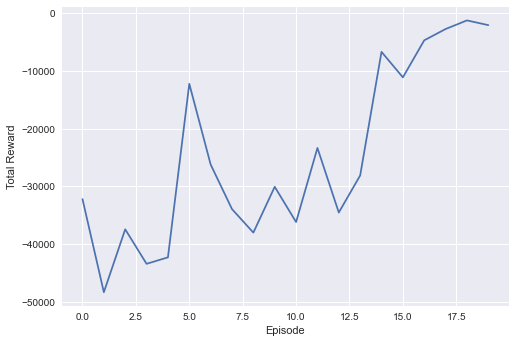


Mean is -108.00688254398284
variance is 17746.324247015942


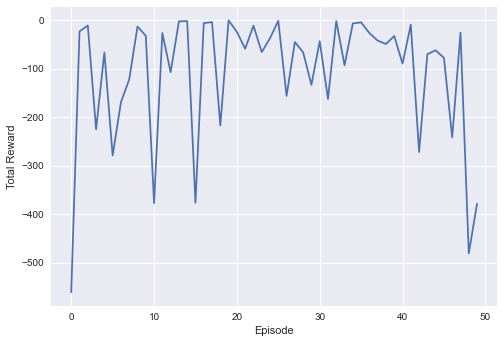

Training for actor learning rate : 1e-05 critic learning rate : 0.005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


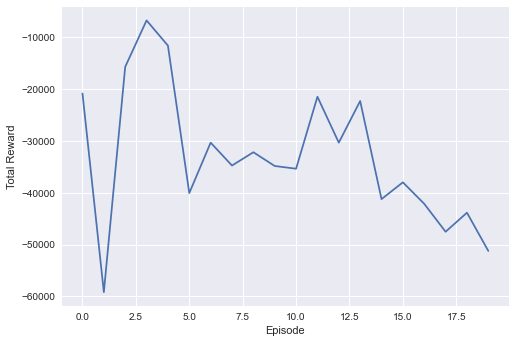


Mean is -9556.799285834835
variance is 1318727.6388591572


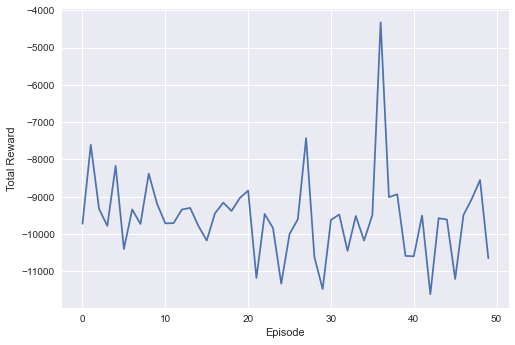

Training for actor learning rate : 1e-05 critic learning rate : 0.007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


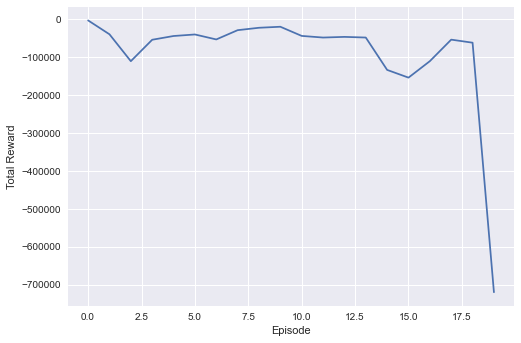


Mean is -80649.01766690078
variance is 742486152.3533238


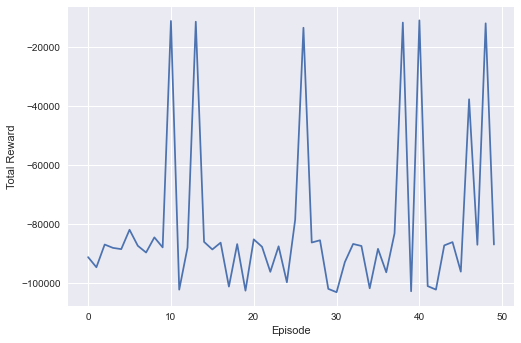

Training for actor learning rate : 5e-05 critic learning rate : 0.001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


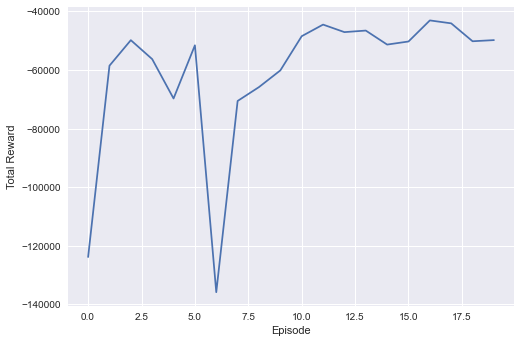


Mean is -8153.712090327705
variance is 3326555.5542576457


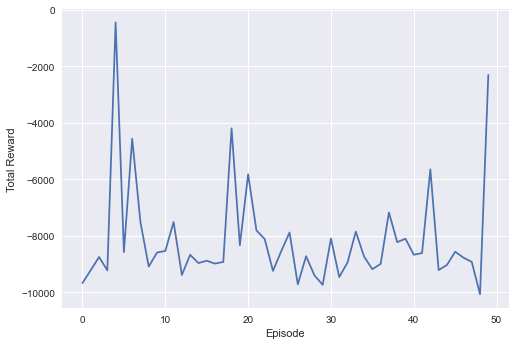

Training for actor learning rate : 5e-05 critic learning rate : 0.003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


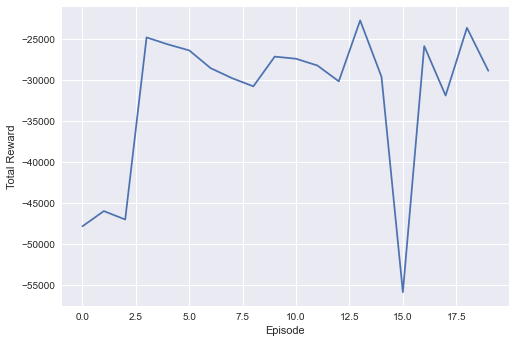


Mean is -5248.631581745585
variance is 330448.6680206745


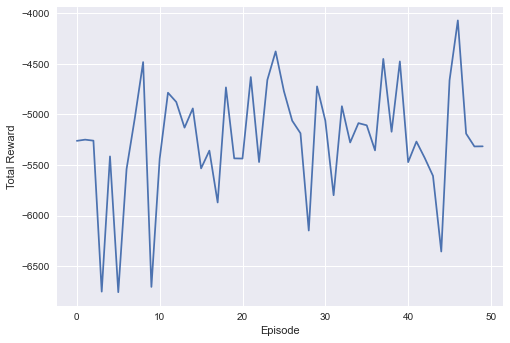

Training for actor learning rate : 5e-05 critic learning rate : 0.005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


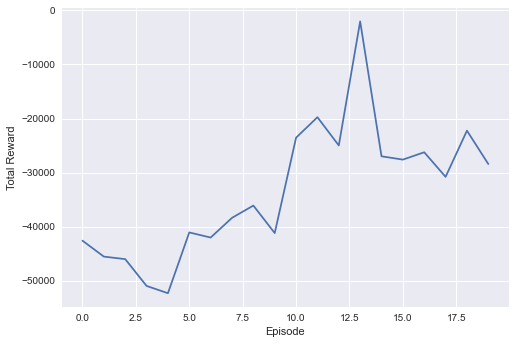


Mean is -5562.866392963868
variance is 308826.82815985446


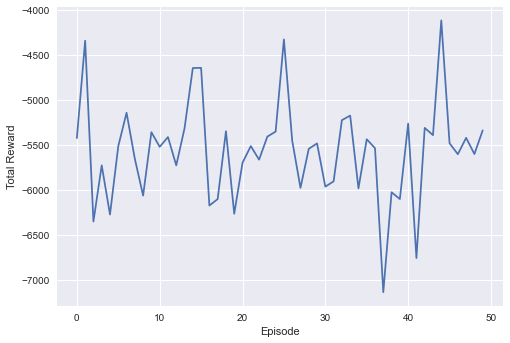

Training for actor learning rate : 5e-05 critic learning rate : 0.007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


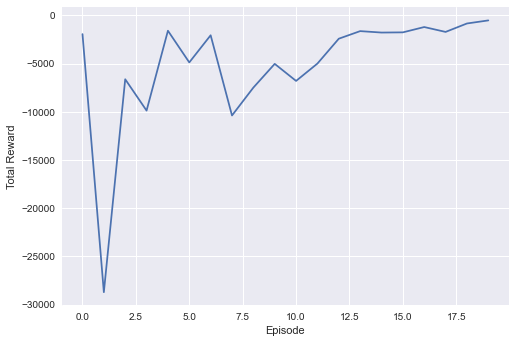


Mean is -177.9059746347544
variance is 22926.67701577633


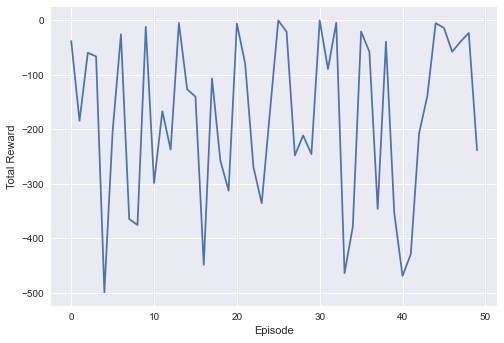

Training for actor learning rate : 8e-05 critic learning rate : 0.001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


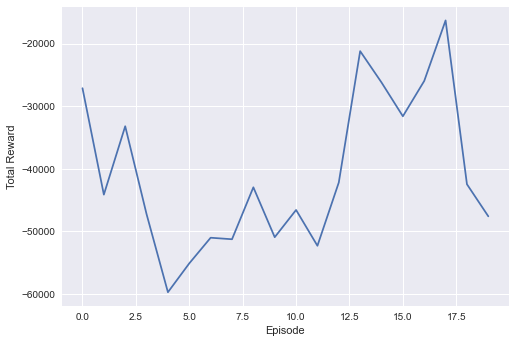


Mean is -7937.349902115222
variance is 6602961.682475123


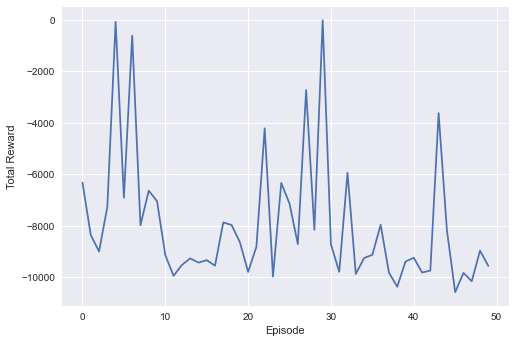

Training for actor learning rate : 8e-05 critic learning rate : 0.003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


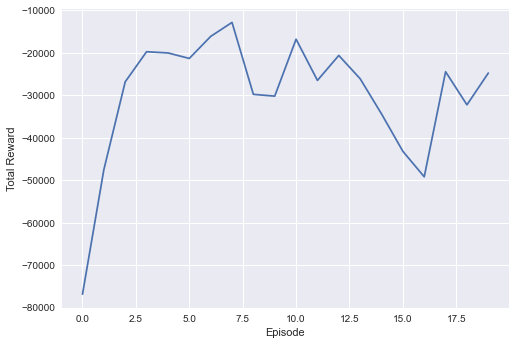


Mean is -5589.5153465786025
variance is 1079150.4317932175


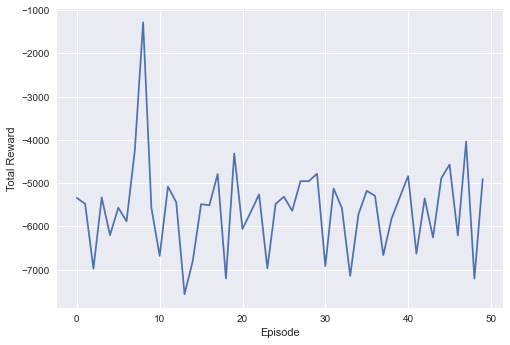

Training for actor learning rate : 8e-05 critic learning rate : 0.005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


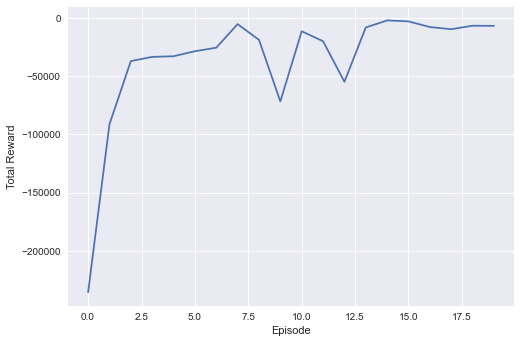


Mean is -745.5945454067967
variance is 226647.04235926142


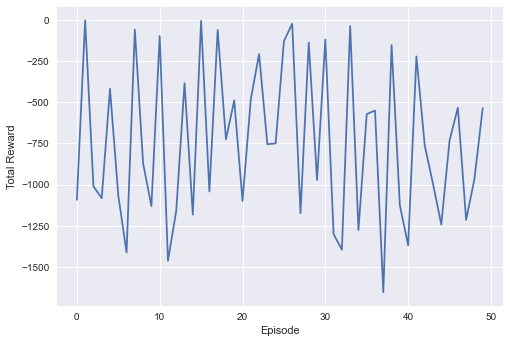

Training for actor learning rate : 8e-05 critic learning rate : 0.007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


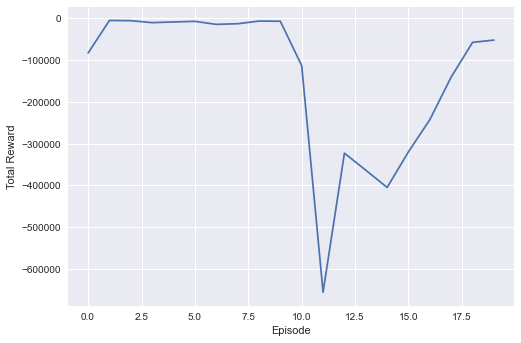


Mean is -10603.661489462238
variance is 480909.4403158294


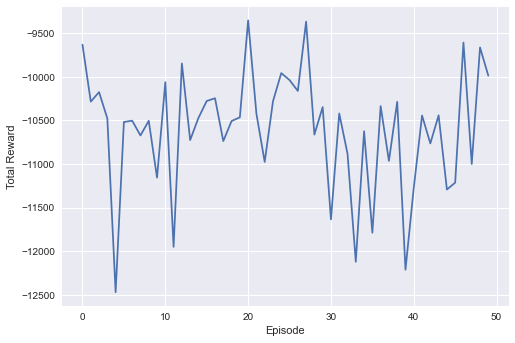

Training for actor learning rate : 2e-06 critic learning rate : 0.001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


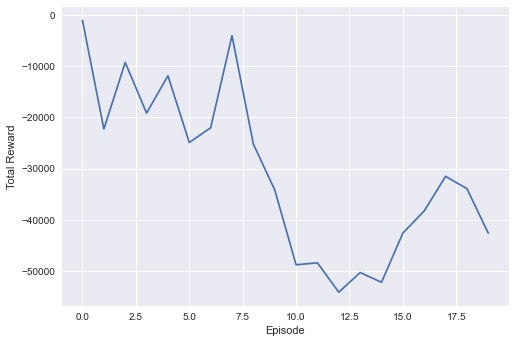


Mean is -7340.485807691718
variance is 455280.6121928651


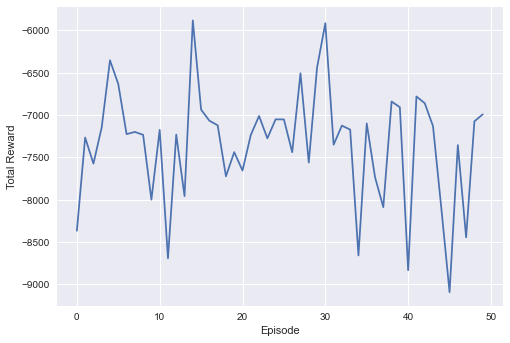

Training for actor learning rate : 2e-06 critic learning rate : 0.003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


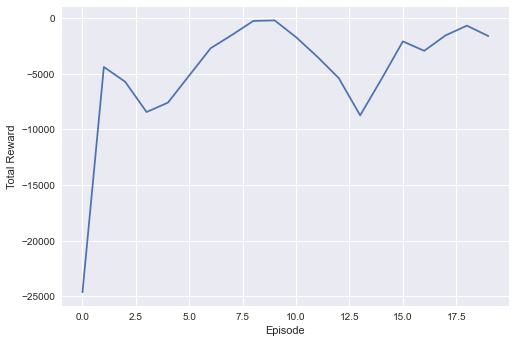


Mean is -106.31675627589755
variance is 13035.568596419895


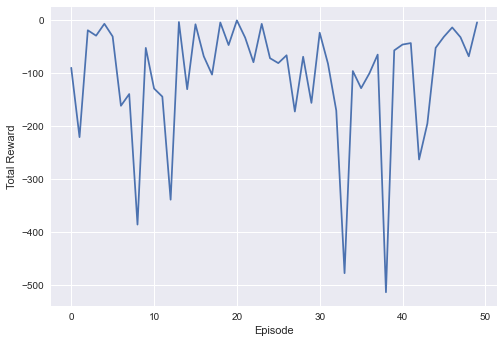

Training for actor learning rate : 2e-06 critic learning rate : 0.005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


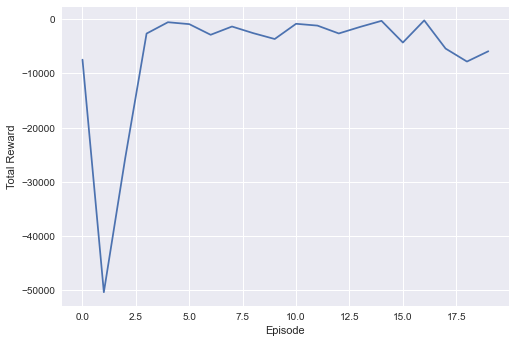


Mean is -1375.1950442928103
variance is 281599.62940786476


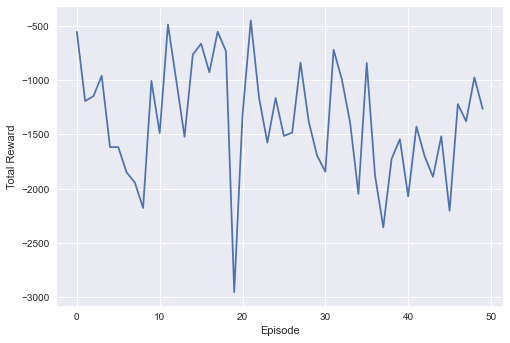

Training for actor learning rate : 2e-06 critic learning rate : 0.007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


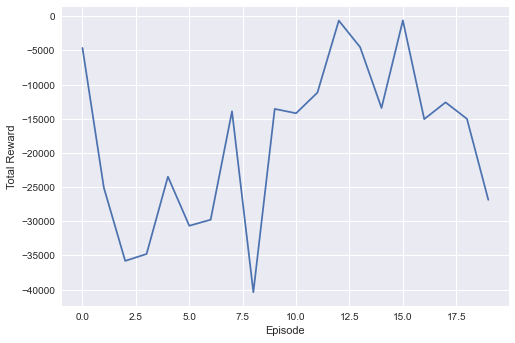


Mean is -2085.212101004747
variance is 5105233.383912138


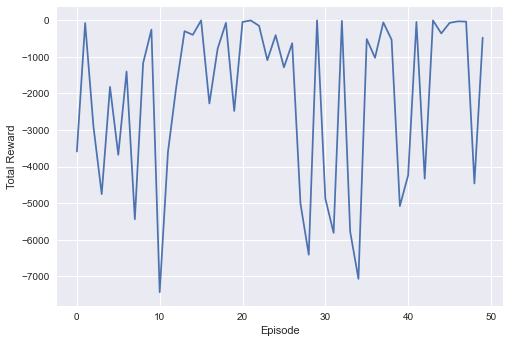

Training for actor learning rate : 5e-06 critic learning rate : 0.001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


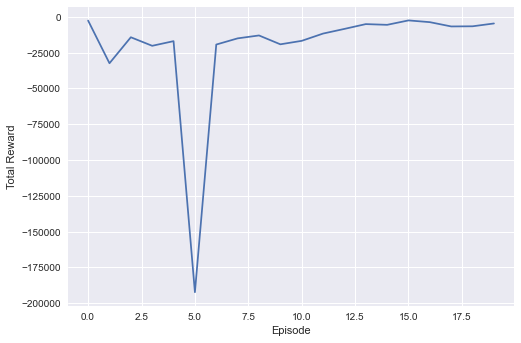


Mean is -417.93069054716216
variance is 150994.0294971522


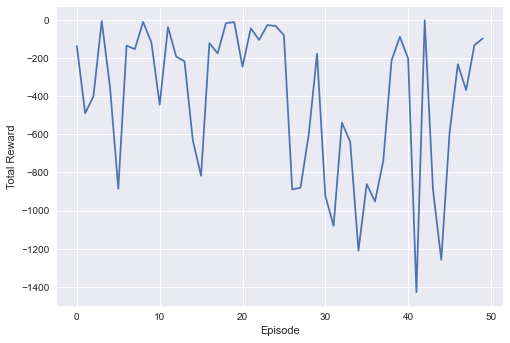

Training for actor learning rate : 5e-06 critic learning rate : 0.003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


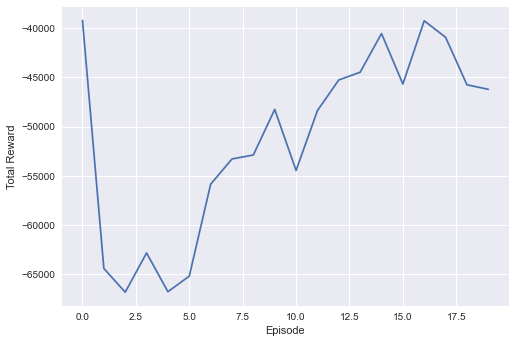


Mean is -8018.9822001993025
variance is 4593041.792929092


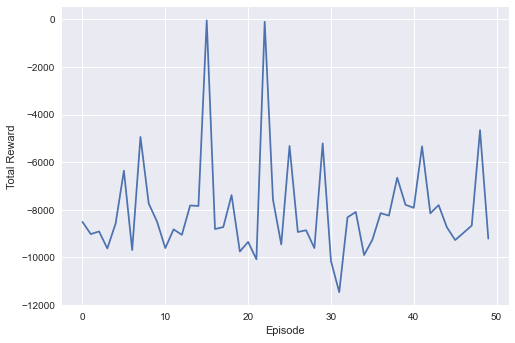

Training for actor learning rate : 5e-06 critic learning rate : 0.005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


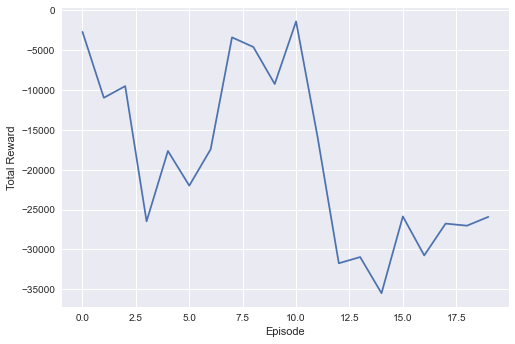


Mean is -4967.906820418872
variance is 1608512.2374897022


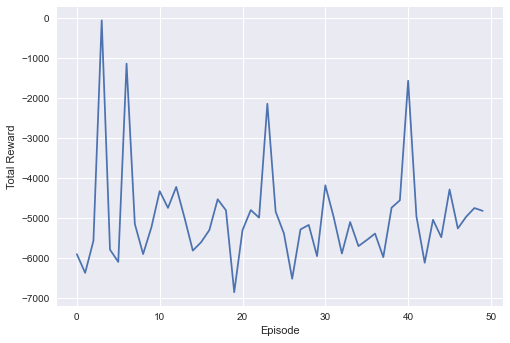

Training for actor learning rate : 5e-06 critic learning rate : 0.007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


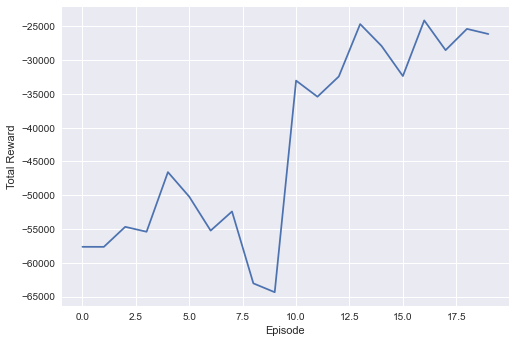


Mean is -6252.931420746572
variance is 358020.94924540445


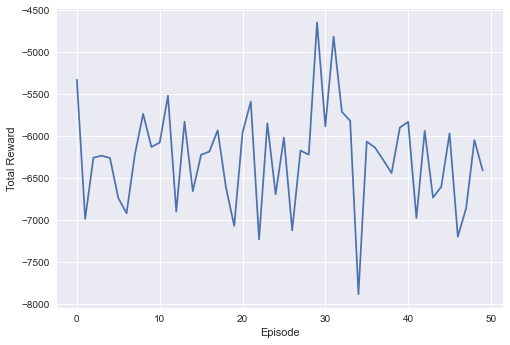

Training for actor learning rate : 8e-06 critic learning rate : 0.001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


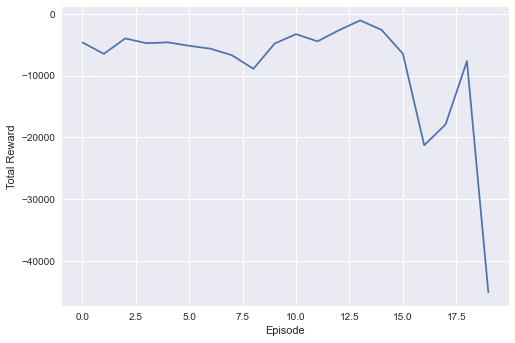


Mean is -12202.369738433803
variance is 987186.8798871553


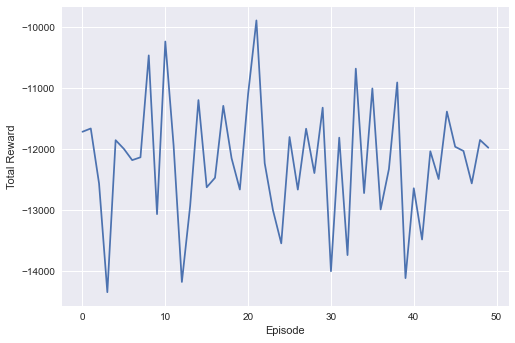

Training for actor learning rate : 8e-06 critic learning rate : 0.003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


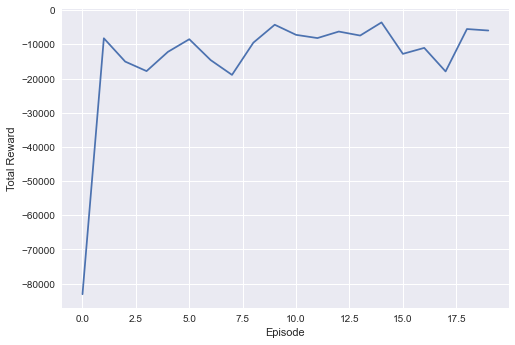


Mean is -683.9485278573479
variance is 258240.30290488887


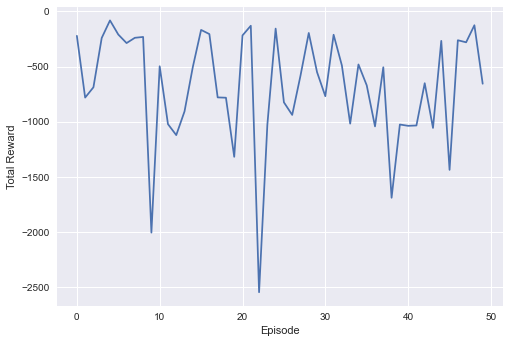

Training for actor learning rate : 8e-06 critic learning rate : 0.005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


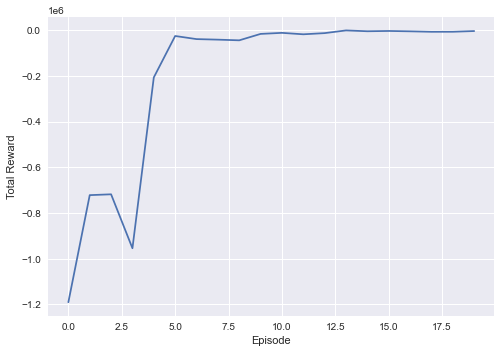


Mean is -491.6707557003632
variance is 104040.94116878748


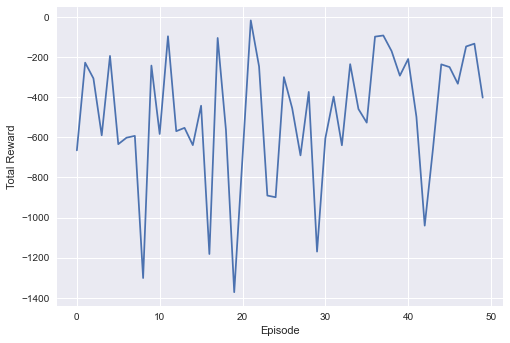

Training for actor learning rate : 8e-06 critic learning rate : 0.007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.


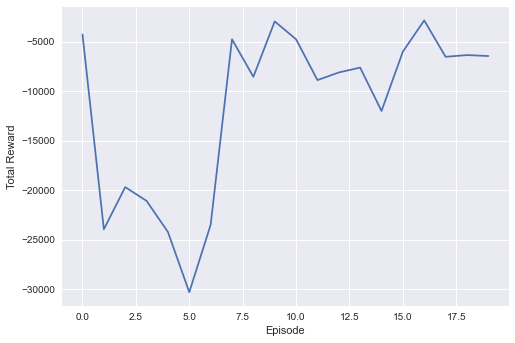


Mean is -1294.115000914727
variance is 93785.92340017525


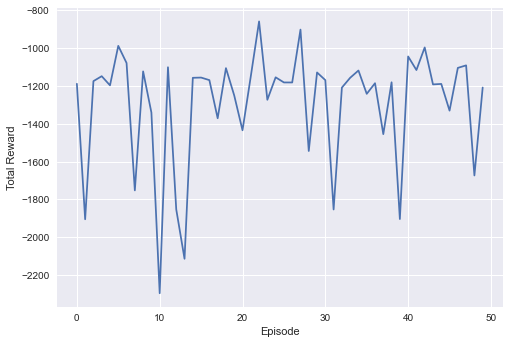

In [12]:
log = []
for i in range(len(actor_lr_list)):
    for j in range(len(critic_lr_list)):
        print('Training for actor learning rate : ' + str(actor_lr_list[i]) + ' critic learning rate : '+ str(critic_lr_list[j]))
        agent = DDPGAgent(env,actor_lr_list[i],critic_lr_list[j])

        tr_log = agent.train()
        log.append(tr_log)
        #make simple moving average over 5 episodes (smoothing) and plot
        SMA_rewards = np.convolve(tr_log['cum_rew'], np.ones((1,))/1, mode='valid')
        #Plot learning curve
        plt.style.use('seaborn')
        plt.plot(SMA_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

        test_log = test() 
        #make simple moving average over 5 episodes (smoothing) and plot
        SMA_rewards = np.convolve(test_log['cum_rew'], np.ones((1,))/1, mode='valid')
        #Plot learning curve
        plt.style.use('seaborn')
        plt.plot(SMA_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

In [13]:
actor_lr_list = [0.00001,0.00005,0.00008,0.000002,0.000005,0.000008 ]
critic_lr_list = [0.0001,0.0003,0.0005,0.0007]

Training for actor learning rate : 1e-05 critic learning rate : 0.0001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-3821.5026870011957, -40425.337038956786, -23984.3675613978, -14266.446949108693, -11217.985084741567, -24679.139658960295, -13130.123815826728, -8798.51012604902, -16277.003941684967, -24300.337379218086, -18831.289280579815, -15055.120011012461, -13890.887445616836, -14578.871511728665, -29600.100480787536, -33361.13827164528, -50114.89716974197, -51971.72609088811, -56368.53503698911, -40647.64436979441], 'critic_loss': [nan, 2.0462685, 95.16117, 269.54956, 721.36566, 1909.0812, 39661.973, 1945606.5, 22296310.0, 180645040.0, 1158623500.0, 7381061000.0, 24044761000.0, 20983520000.0, 16271909000.0, 17090482000.0, 17373160000.0, 28763470000.0, 23192270000.0, 21359933000.0], 'actor_loss': [nan, -8.992688, -210.10619, -352.60858, -457.7309, -568.39575, -1469.1318, -6667.962, -21373.395, -55647.797, -129244.37, -291472.78, -631931.9, -818779.4, -991157.94, -1175453.5, -1307701.5, -2105952.8, -2871817.5, -3254798.0]}


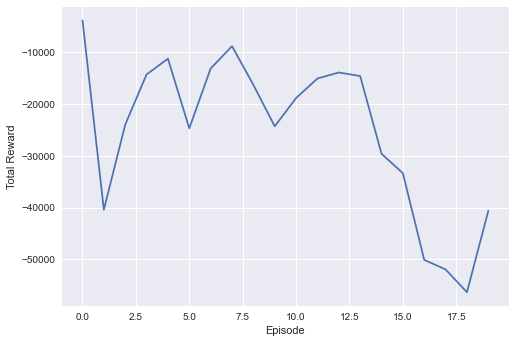


Mean is -9743.516967533737
variance is 2036671.2860134712


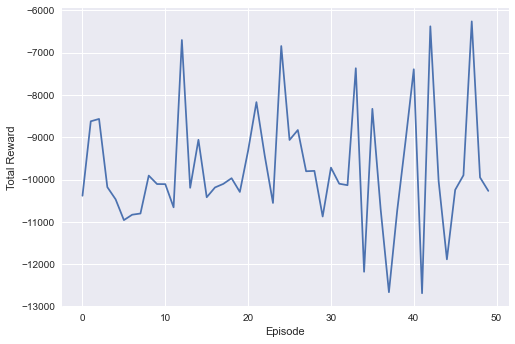

Training for actor learning rate : 1e-05 critic learning rate : 0.0003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-985.2131097233191, -22972.95095965713, -29782.976875403878, -50545.832664194946, -33169.18505553981, -34707.63843245523, -25269.912194920587, -24805.098073309127, -26430.37097345367, -27251.476806775627, -21663.410745628116, -22009.33197217131, -33392.267866728434, -31671.2039874882, -18367.81487537869, -26267.872465060602, -33332.96890274551, -20312.594532915085, -21282.692743474214, -18503.489088173083], 'critic_loss': [nan, 0.05786427, 0.22295257, 1.1231271, 2.473493, 2.3821962, 4.549332, 6.6689205, 7.7109904, 8.614266, 10.274691, 12.879485, 19.360615, 23.686975, 24.513182, 26.73577, 28.215862, 28.577127, 30.441044, 39.435406], 'actor_loss': [nan, 2.4388466, 13.453062, 29.912909, 43.08026, 63.034832, 83.69239, 94.86371, 108.35667, 123.498566, 137.71771, 147.16074, 156.82533, 169.42227, 180.8064, 191.07085, 201.43123, 211.52489, 214.49187, 205.98955]}


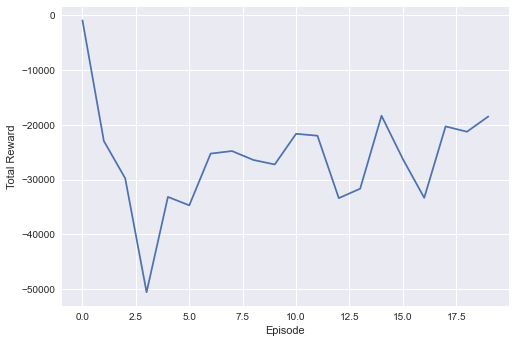


Mean is -4257.853988562477
variance is 2168293.749298126


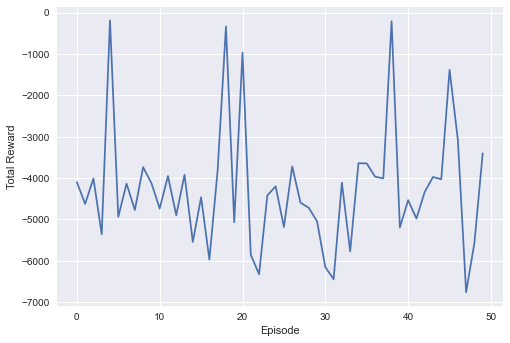

Training for actor learning rate : 1e-05 critic learning rate : 0.0005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-47102.63303201186, -49394.59091435488, -93881.65013710738, -50702.39679529076, -19834.481259343615, -8103.718011325774, -10456.287560845807, -7932.3715753792785, -4202.0896688759, -8273.582392852857, -3781.8320232154424, -22217.757487449395, -46057.30482256065, -22812.67242450915, -64275.965399254805, -126454.11675567151, -38606.11893505438, -296414.8899023056, -116662.07155562432, -55690.10359494559], 'critic_loss': [nan, 3.0310464, 13.532525, 39.75499, 71.576546, 59.79115, 55.49814, 67.6133, 76.660736, 139.90036, 133.97789, 155.93314, 206.65065, 372.35617, 241.02838, 269.2534, 398.747, 713.2935, 1411.6316, 2897.0085], 'actor_loss': [nan, 25.373915, 49.489143, 100.679184, 126.57577, 126.80645, 127.91361, 130.09584, 125.46468, 104.31581, 68.44497, 63.30946, 67.93136, 62.7784, 58.20235, 54.95135, 53.266678, 62.854946, 81.11173, 53.078186]}


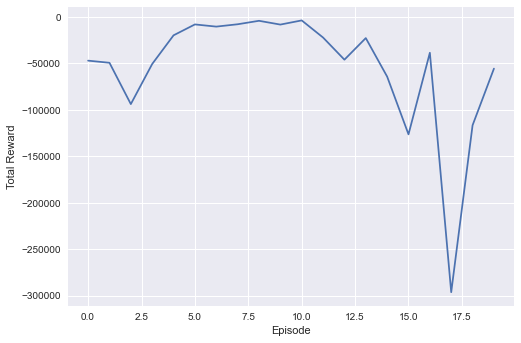


Mean is -11105.414204182098
variance is 2235884.2494801665


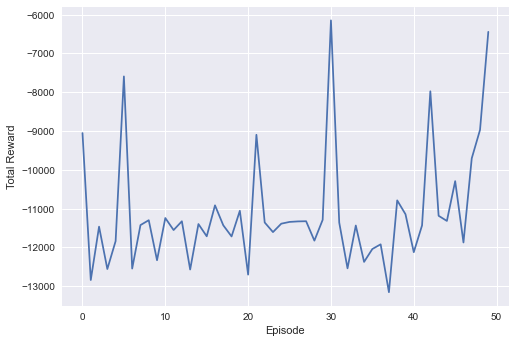

Training for actor learning rate : 1e-05 critic learning rate : 0.0007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-3333.1639055990336, -4741.500642890001, -1857.5064806605583, -2078.174976037899, -2538.8584044313975, -333.72024014043495, -498.30168029783806, -322.24065411631534, -295.30051566116293, -254.5683585700011, -373.8562721784333, -142.21046223984385, -367.81287894311015, -328.4384671217397, -256.9577664756243, -324.90991423561894, -151.63770614159574, -69.9038080317521, -314.4415897235201, -42.87586277797285], 'critic_loss': [nan, 0.011669825, 0.01385478, 0.021514691, 0.03937633, 0.07914159, 0.0905005, 0.080940224, 0.06735721, 0.06348015, 0.059530407, 0.05184103, 0.03948014, 0.034612052, 0.032388948, 0.032712825, 0.03339296, 0.03408958, 0.033161834, 0.031649686], 'actor_loss': [nan, 1.7076113, 2.3120909, 3.1880002, 3.583303, 4.051179, 3.9807796, 3.6361365, 3.2066598, 2.8672664, 2.8207324, 2.7214973, 2.549158, 2.5611932, 2.6092613, 2.5850654, 2.61476, 2.5847297, 2.6092966, 2.5715759]}


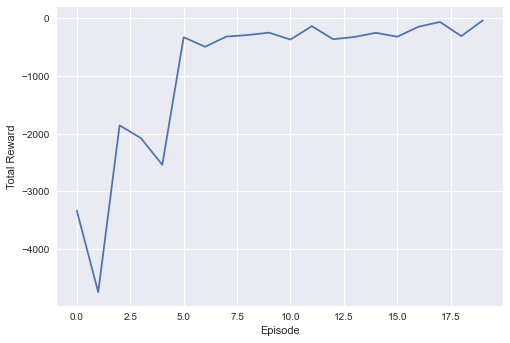


Mean is -19.321464306773045
variance is 447.01087197318776


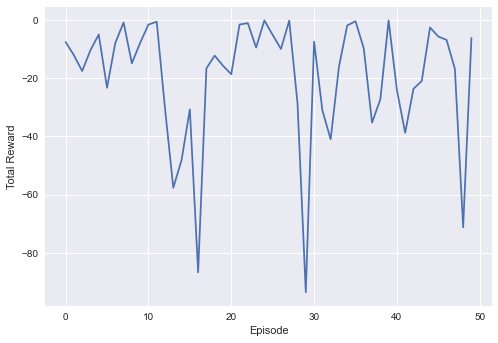

Training for actor learning rate : 5e-05 critic learning rate : 0.0001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-470673.4250511692, -33736.16351974629, -19699.013281550142, -37266.0194270298, -24781.444312228057, -1802.7506662032038, -3237.3867589520028, -2845.5556199129487, -1075.9003676118853, -7592.0996703416, -2918.6842624992814, -973.04895201868, -3184.0536003440834, -1445.8917570678022, -33172.63428637329, -35261.17557073576, -40281.160008121646, -81300.67484893124, -77232.538986462, -88790.71179204155], 'critic_loss': [nan, 187.4282, 90.059784, 819.6783, 5154.9575, 21419.365, 76981.43, 198242.1, 418671.94, 721830.06, 1173294.0, 1726298.9, 2317479.0, 3366826.8, 4986078.0, 6994281.5, 10237750.0, 12617791.0, 13349218.0, 14925275.0], 'actor_loss': [nan, 161.55064, 208.77748, 157.21573, -141.96228, -783.7772, -2182.9429, -4518.1675, -7847.322, -11002.749, -14688.839, -19551.867, -23931.453, -27734.875, -32504.154, -38443.223, -46227.83, -54005.6, -60310.465, -65137.062]}


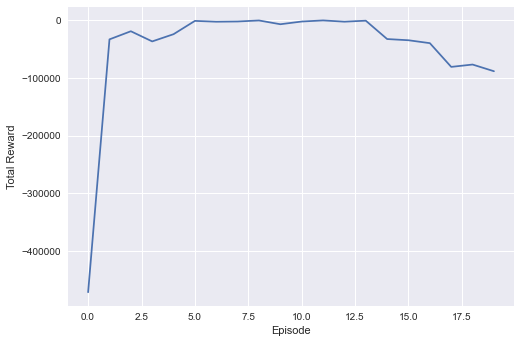


Mean is -15973.333732326708
variance is 5453584.644038851


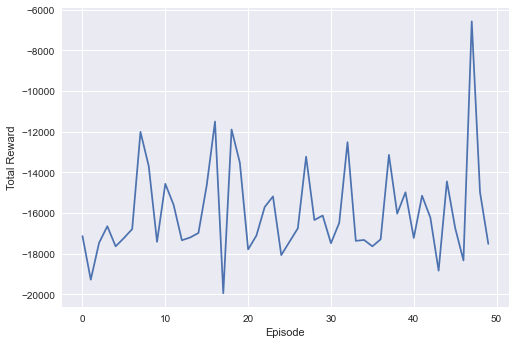

Training for actor learning rate : 5e-05 critic learning rate : 0.0003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-100693.38953417266, -45799.30579682808, -30475.87361801849, -32415.33694561783, -23966.79512140974, -26146.40333383182, -38045.72407364179, -21537.682767112885, -18217.31807478705, -4757.170564523952, -5089.52977863059, -4767.382114921761, -2309.108101056946, -13269.261144152073, -3696.422411599774, -10105.147672072144, -37687.441203786424, -35857.8674993049, -39504.55517792069, -57932.22634465905], 'critic_loss': [nan, 11.629769, 15.174541, 11.131088, 12.918751, 14.597494, 17.404562, 20.559828, 26.247993, 27.754747, 27.796585, 30.938171, 39.8581, 99.051125, 145.77419, 22983.775, 11642852.0, 466686900.0, 5217090000.0, 27357544000.0], 'actor_loss': [nan, 45.320335, 60.758358, 83.59342, 106.406166, 121.72312, 141.07295, 163.29646, 175.93053, 175.89168, 170.93376, 163.26013, 151.849, 125.43565, 79.35652, -941.4011, -28661.65, -181068.95, -543410.5, -1275096.5]}


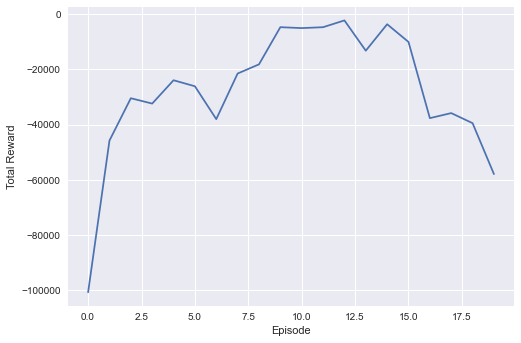


Mean is -12045.032339911902
variance is 457817.0566418262


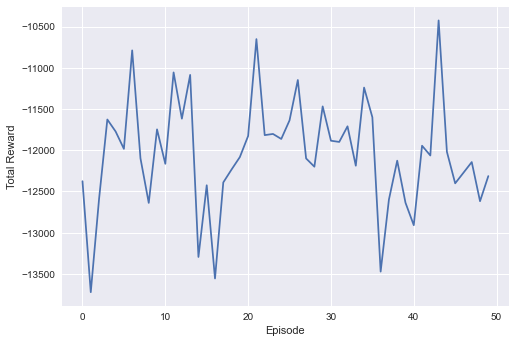

Training for actor learning rate : 5e-05 critic learning rate : 0.0005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-774.8692344486287, -38103.503974325795, -48984.287710666285, -25339.71859272672, -22605.003942764753, -32883.64804792635, -25938.912730458884, -26458.379745137856, -28186.49579461795, -24157.204608076507, -33192.430892063654, -30411.250977564432, -29092.399365265454, -21334.835256032642, -30713.967203885168, -34013.094274939016, -28149.579901005807, -28438.483656768178, -26773.023625169837, -26966.372698747018], 'critic_loss': [nan, 0.6236264, 15.287968, 25.898232, 41.324966, 88.1706, 151.25963, 194.6437, 230.03156, 205.63937, 197.83461, 190.59592, 233.43704, 227.2092, 143.10023, 128.59532, 103.64317, 115.61721, 136.7508, 128.03723], 'actor_loss': [nan, 1.0840213, 7.7577243, 26.41652, 23.694424, 26.388174, 32.409233, 39.819603, 52.523216, 72.23486, 92.94557, 121.06604, 150.2181, 185.04712, 215.01988, 243.70848, 270.3972, 296.13107, 319.2082, 334.77014]}


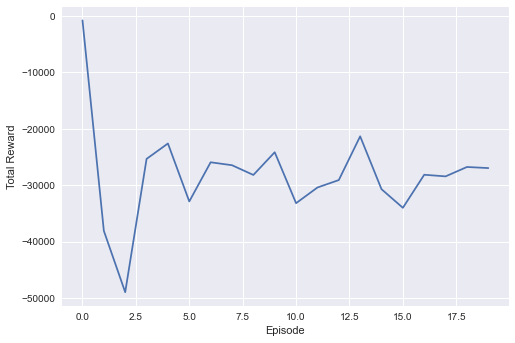


Mean is -6176.496034729308
variance is 418111.74015380105


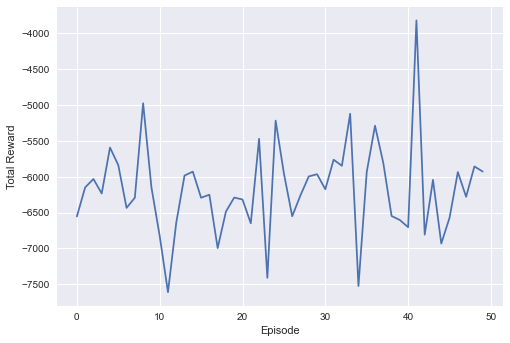

Training for actor learning rate : 5e-05 critic learning rate : 0.0007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-1404236.142439279, -756497.7277065364, -31217.07569507435, -27749.061780155233, -28793.398351713557, -24418.677042252584, -894024.1706205511, -1269132.9291758253, -878629.5781866473, -791230.0313913097, -15060.214851601422, -19874.40625374549, -22490.667467074356, -29472.89397500467, -18191.8939528414, -43236.930025695554, -42438.179918196576, -39262.015027417, -35840.178221013855, -26734.165993375154], 'critic_loss': [nan, 585.6834, 626.90875, 2519.6975, 5994.8564, 21785.373, 140693.61, 291772.72, 505273.12, 553431.56, 4331809.5, 1510998.5, 1934833.9, 10653110.0, 46967410.0, 61913004.0, 64549828.0, 63556604.0, 64778344.0, 60182264.0], 'actor_loss': [nan, 670.1312, 1245.4529, 1379.1519, 1418.6127, 1340.8219, 864.3678, 848.2666, 390.23285, 402.3801, -3999.6348, -8378.169, -10015.798, -16020.964, -49536.594, -83336.93, -108004.06, -122052.25, -139185.64, -149468.42]}


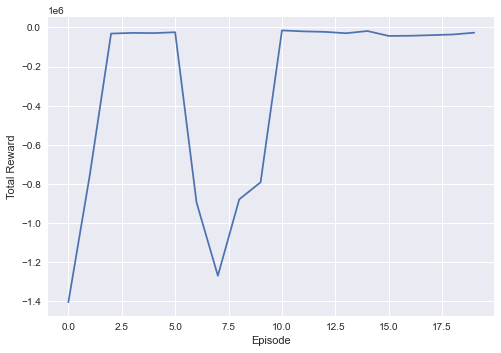


Mean is -6133.594715561035
variance is 162846.86687085012


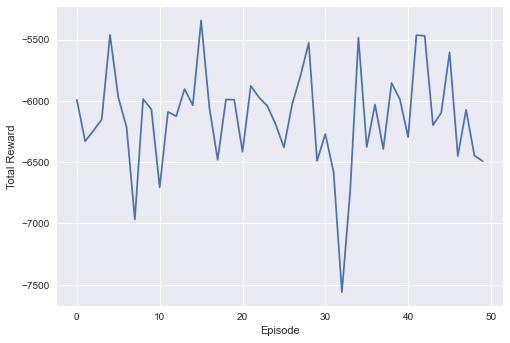

Training for actor learning rate : 8e-05 critic learning rate : 0.0001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-46506.52963149669, -50078.27971099628, -59400.27622790969, -50597.13222845971, -33991.56139225792, -44591.419329122255, -44774.8206800209, -68352.79558424676, -65476.41091700938, -50162.95723861165, -54734.74824869946, -49248.48220720245, -33219.28550814596, -6936.16785003341, -8756.911877765739, -12867.984645573471, -34684.47345152178, -51284.33281373296, -50291.40189936345, -63399.678529875164], 'critic_loss': [nan, 0.5622182, 0.7987578, 6663.9575, 71614.445, 599277.56, 857005.9, 1972057.6, 3791953.0, 5975634.5, 8865130.0, 12361867.0, 15098865.0, 18959612.0, 21700522.0, 24413402.0, 25297466.0, 24545334.0, 23760912.0, 25679122.0], 'actor_loss': [nan, 20.618662, 69.43503, -278.51822, -3501.4385, -8534.369, -14573.479, -18180.22, -22783.51, -27553.902, -32322.37, -39459.273, -52028.094, -60941.402, -66716.21, -70295.04, -71861.91, -70808.62, -67431.875, -63757.133]}


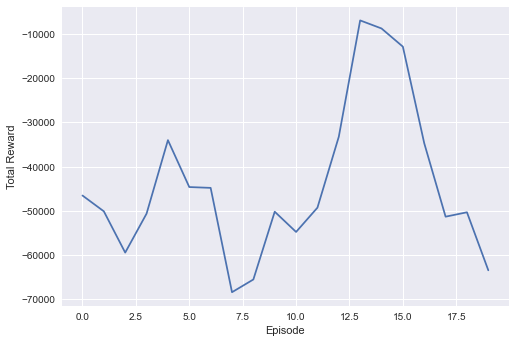


Mean is -12104.298364813541
variance is 464790.95092310646


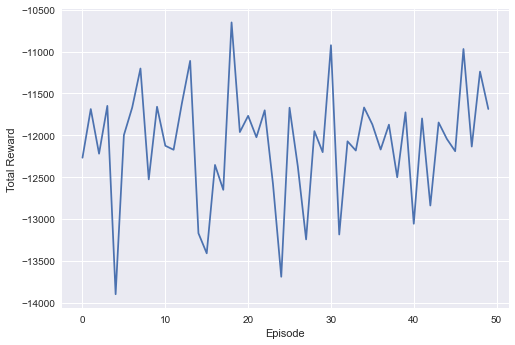

Training for actor learning rate : 8e-05 critic learning rate : 0.0003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-411988.8378311918, -501208.324113563, -622680.2828644654, -586421.8338845307, -527348.1838438079, -649979.263671917, -590369.6639375358, -542796.7582262934, -393629.85576042905, -476101.25296470965, -451443.15655245626, -430185.1428668424, -392734.0908085556, -359868.04268194735, -335594.2287033775, -170580.26435761026, -50168.87820509864, -58879.55659972979, -48048.12585542311, -41336.85540052223], 'critic_loss': [nan, 75.23039, 51.55378, 146.87337, 794.4209, 6888.7666, 113536.305, 1642127.8, 8856249.0, 37230736.0, 107790390.0, 251943330.0, 530871580.0, 1115899000.0, 2152753400.0, 3641410800.0, 4233038300.0, 5847852500.0, 7710954500.0, 6300615700.0], 'actor_loss': [nan, 247.23355, 675.1193, 1148.0717, 1584.0542, 1959.5659, 2159.7832, 1376.9886, -514.07513, -4213.186, -9850.057, -17122.787, -26944.777, -41553.688, -62628.297, -89690.33, -136171.42, -270745.78, -428431.66, -456294.84]}


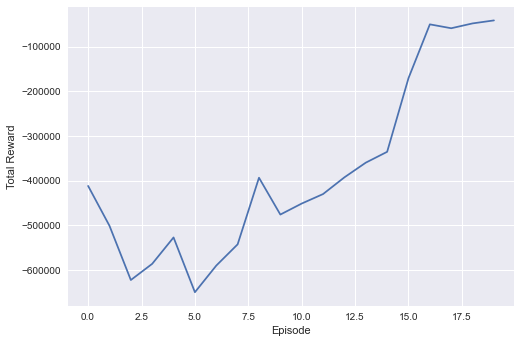


Mean is -9977.6519556344
variance is 5594777.4689048715


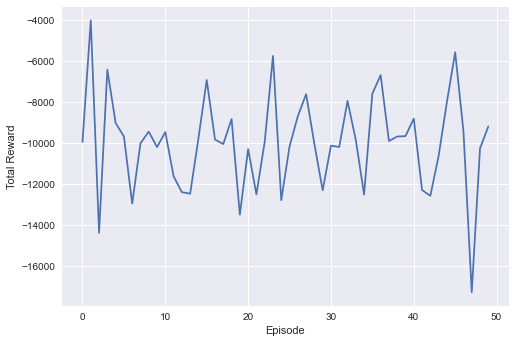

Training for actor learning rate : 8e-05 critic learning rate : 0.0005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-30459.30957175876, -25213.323763830405, -48707.810215626545, -32553.50136573706, -33630.25521996863, -345454.3940832396, -850523.7311236099, -262230.1666781396, -27726.05993848528, -7581.640993839875, -7400.596090231198, -7906.352766469152, -13498.833675095646, -5859.967738482565, -8308.88460752221, -5372.18836626502, -18611.68629013769, -9834.849354088587, -25137.957604640058, -12435.206462824293], 'critic_loss': [nan, 0.13152297, 0.594238, 63.04452, 1855.3077, 44127.027, 647925.7, 1824550.5, 2951884.8, 3332031.5, 2701799.8, 2690204.5, 3590693.2, 3234413.8, 3181149.8, 3154180.0, 3285894.0, 3253655.0, 4037979.0, 5641578.0], 'actor_loss': [nan, 15.293249, 45.699127, 61.77672, -5.757683, -273.05328, -1113.6064, -2214.962, -2294.3445, -3275.868, -5960.326, -10531.639, -16907.213, -22062.285, -26177.996, -28977.725, -33146.004, -36736.35, -39378.785, -41400.547]}


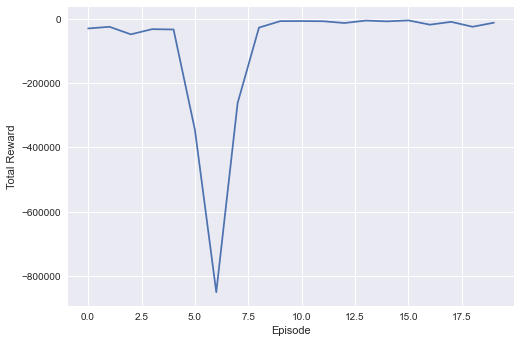


Mean is -1540.9321599059313
variance is 1931035.346336817


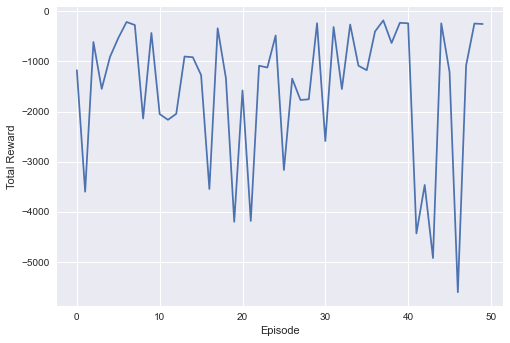

Training for actor learning rate : 8e-05 critic learning rate : 0.0007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-1384536.621522732, -771577.3313028923, -31741.19295192806, -797480.2988502637, -33102.738764019035, -32238.055131371333, -356244.91319851635, -40541.570665380736, -31241.57171795616, -24731.7042700616, -19418.42952591622, -27813.436212403583, -29241.34301166442, -33615.1737497185, -54007.87883146514, -54652.64968116223, -47833.39033929953, -47868.54934816021, -15675.72013074886, -20189.413537467266], 'critic_loss': [nan, 601.8793, 724.959, 1914.2676, 4525.4375, 11036.325, 31968.695, 39785.348, 102532.625, 222546.84, 506641.5, 1032663.06, 2069486.1, 4107482.0, 10428362.0, 17424270.0, 29126872.0, 58009344.0, 100128500.0, 124734776.0], 'actor_loss': [nan, 665.8645, 1295.1062, 1622.4725, 2045.4722, 2038.7677, 1993.665, 1875.4637, 1539.3456, 274.15866, -2598.6125, -8402.577, -15836.524, -26586.074, -48386.16, -83226.57, -120166.51, -157148.72, -202820.39, -232957.88]}


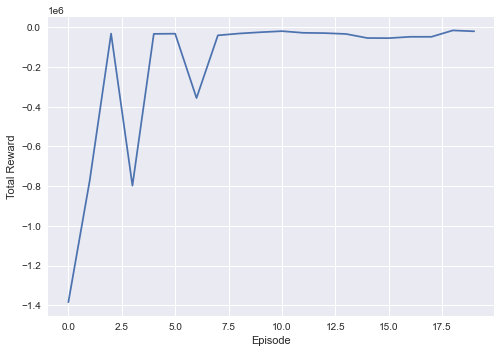


Mean is -5852.034545995941
variance is 1092502.2201120905


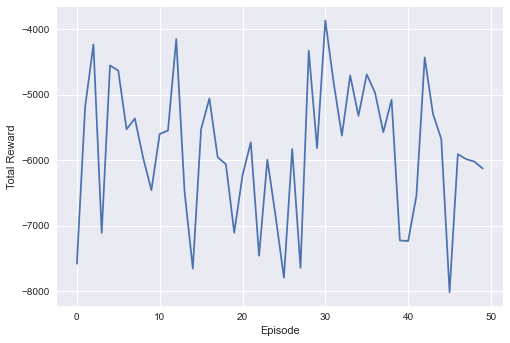

Training for actor learning rate : 2e-06 critic learning rate : 0.0001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-53868.43880319931, -4474.429413355509, -1992.5954301001634, -1572.5594082847292, -1670.9109374795362, -959.1579718374682, -1665.5235694288065, -1424.4281194916375, -894.848891407385, -3518.028824423242, -1019.4727971048025, -3008.5072655071795, -2046.544137733824, -1077.8550770266993, -412.2318035035465, -902.389433598145, -1430.2413925303629, -74.56815712120867, -567.3362960249948, -959.0171690951142], 'critic_loss': [nan, 3.1593676, 0.20720346, 0.31512025, 0.34096807, 0.3215931, 0.33104402, 0.3289224, 0.28075498, 0.27577242, 0.28841212, 0.3706753, 0.40607744, 0.3760002, 0.4102744, 0.44195548, 0.4743971, 0.50480616, 0.4878542, 0.5189262], 'actor_loss': [nan, 16.355988, 20.942808, 20.86185, 18.912184, 17.271275, 16.28972, 15.053483, 13.838994, 13.084113, 12.599527, 12.448295, 12.40883, 12.254357, 11.663743, 11.107109, 11.284935, 11.05258, 10.796183, 10.832504]}


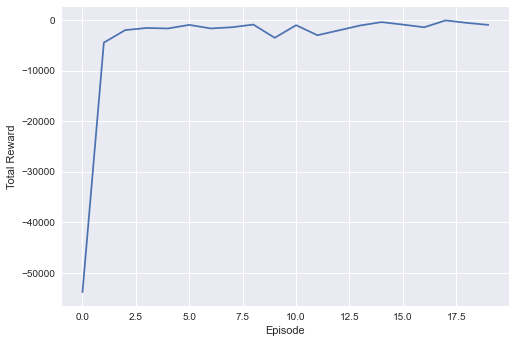


Mean is -79.48239185810236
variance is 7239.94529219242


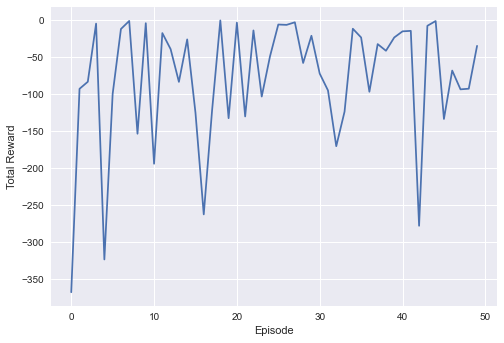

Training for actor learning rate : 2e-06 critic learning rate : 0.0003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-140638.4268813694, -60167.21153261935, -75262.37587726733, -91287.27397485514, -78591.25757380658, -99834.98547874892, -89839.89355014247, -56877.1280939485, -50923.88792253263, -57837.658676267354, -47566.60006357491, -60912.523647213304, -51786.306336254944, -45923.28451339741, -47547.395913588734, -53556.6979428483, -49405.89542494752, -47426.0586480591, -47679.734215851495, -47212.83799500024], 'critic_loss': [nan, 13.434974, 33.525585, 138.50708, 471.21976, 1369.6901, 2986.7734, 11526.053, 499089.56, 8733073.0, 69774790.0, 496368740.0, 4005317000.0, 28790591000.0, 159211850000.0, 760998000000.0, 3298215000000.0, 13919315000000.0, 50187377000000.0, 178116970000000.0], 'actor_loss': [nan, 68.97464, 126.644554, 158.3254, 171.10245, 165.25784, 156.76714, 70.72465, -1547.4076, -10083.472, -32986.027, -87803.85, -234048.95, -581829.06, -1341465.8, -2862314.0, -5979353.5, -11977453.0, -22443596.0, -40172220.0]}


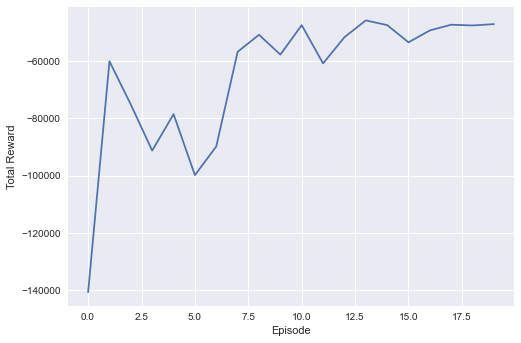


Mean is -9822.218988537357
variance is 730024.0409482992


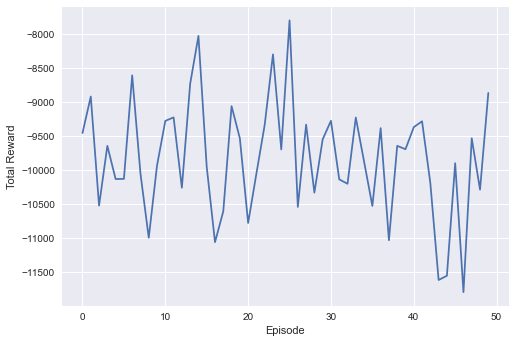

Training for actor learning rate : 2e-06 critic learning rate : 0.0005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-74306.37723558715, -54361.822453791014, -62578.34719611762, -47023.07038810215, -53594.83690596251, -58781.38460317986, -59734.83536621461, -43451.6781632322, -57307.133268019395, -57473.087452660155, -52429.145543134735, -7938.785121388584, -21874.263811904668, -2622.418434131214, -6366.222618943846, -22301.04184396643, -8038.907170257706, -1126.4800254995532, -355.39614021439627, -375.6418152954771], 'critic_loss': [nan, 1.7669466, 4.056238, 15.656818, 47.488625, 100.91008, 133.41182, 108.48455, 69.162224, 56.723484, 71.488884, 119.123825, 70.12792, 55.418446, 50.542656, 50.054832, 50.052742, 47.172768, 44.45487, 45.13921], 'actor_loss': [nan, 42.209114, 89.84908, 131.29495, 159.8618, 188.99664, 247.01366, 301.09634, 344.76495, 382.86746, 409.2697, 376.83652, 374.83243, 330.6615, 263.80972, 216.39813, 189.78888, 157.93199, 136.0545, 119.57143]}


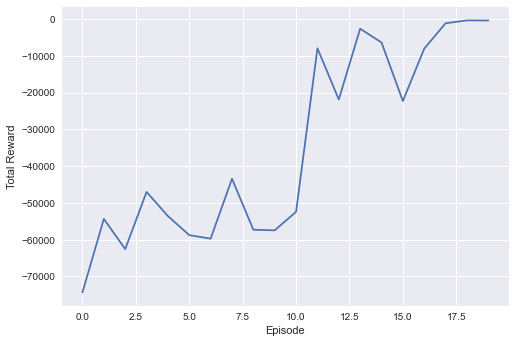


Mean is -120.86965143553594
variance is 14549.708694057214


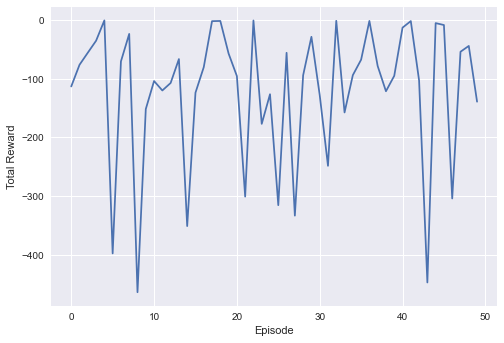

Training for actor learning rate : 2e-06 critic learning rate : 0.0007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-4042.440337083472, -7490.971570359175, -4508.978935010237, -3697.064861411647, -352.1870841599442, -16300.875726493192, -25395.693656479765, -16493.365117100766, -19074.27050521076, -32293.436661773067, -24492.547235268554, -24460.52314716466, -26266.543964217686, -23924.09514779638, -18505.369962444856, -23105.105282087767, -34282.848107699254, -25292.411145748454, -8907.395635695852, -32027.957514577778], 'critic_loss': [nan, 0.05495642, 0.049762543, 0.09324517, 0.1199832, 0.14851479, 0.30677113, 0.578764, 0.9184774, 1.5025129, 2.360421, 3.4132879, 6.665636, 44.85276, 226.58461, 989.73456, 4383.5684, 12007.502, 20097.996, 25939.47], 'actor_loss': [nan, 3.086759, 6.2932887, 9.057004, 8.983201, 10.246031, 18.6412, 27.246424, 37.305977, 52.18403, 68.558815, 80.1432, 91.3128, 87.98101, 58.89099, -88.43314, -450.7369, -794.1913, -1561.6182, -1625.0876]}


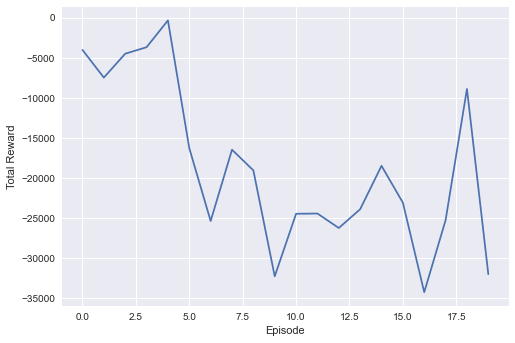


Mean is -4996.554510921815
variance is 696013.7485694452


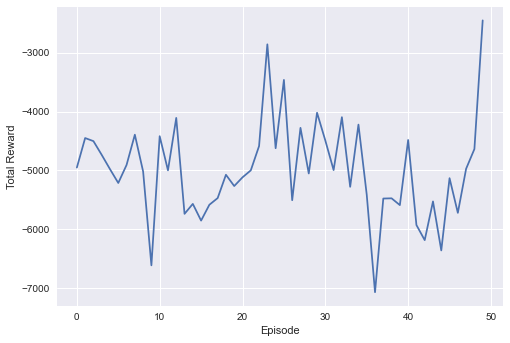

Training for actor learning rate : 5e-06 critic learning rate : 0.0001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-41715.38854732566, -16318.332176804439, -31416.011434668835, -28152.959306215267, -36967.34757790319, -31576.769229754867, -33322.06247232257, -43466.160505439126, -58599.46379692372, -43102.89046636182, -31928.881328327094, -27886.789762067732, -23705.952917711697, -32159.221889080247, -31194.481946473985, -23884.8702678766, -33784.44992607727, -30884.559256708606, -30073.304142907866, -29029.19886108452], 'critic_loss': [nan, 0.80835533, 0.691213, 4.245409, 35.443203, 544.9702, 9162.091, 296789.62, 1466999.5, 2203255.0, 2423020.0, 2470282.5, 2469461.5, 2404012.0, 2285351.2, 2463885.5, 3388410.0, 2254369.0, 2162649.5, 2683878.2], 'actor_loss': [nan, 13.732379, 26.600399, 26.331604, 17.307564, -63.667885, -370.67307, -2296.9705, -6956.308, -5595.127, -3687.0303, -2558.4873, -1751.4894, -1136.4982, -672.8684, -827.7725, -3414.5518, -6321.1846, -8838.453, -11305.033]}


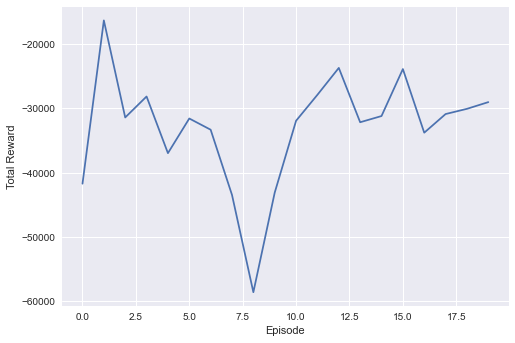


Mean is -6236.197171921334
variance is 411296.9905354857


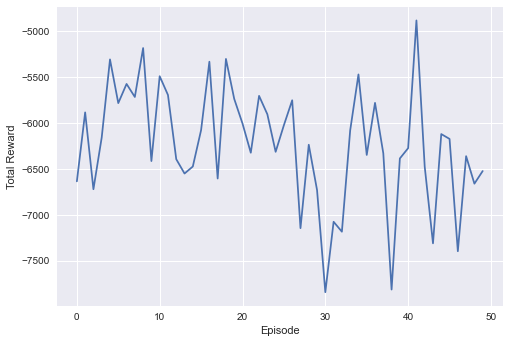

Training for actor learning rate : 5e-06 critic learning rate : 0.0003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-1155.9029809829713, -40593.122049834776, -38273.31456730904, -49679.252293229685, -56088.818500050525, -27758.68834979337, -33136.00976455814, -22133.48566041305, -27080.113393247022, -29960.793175435763, -25869.307123534967, -29659.061505677822, -27962.614058162566, -24235.40451087302, -25181.962430732015, -32485.757407306122, -25540.041000685564, -24918.576195435682, -24837.233875114718, -25322.006482973033], 'critic_loss': [nan, 0.033378694, 0.33319932, 7.855694, 683.5265, 2093.4507, 5697.259, 19374.22, 92852.94, 395217.78, 1779718.4, 6296563.5, 17439900.0, 43384970.0, 102653160.0, 224376820.0, 412048540.0, 764364200.0, 1379288300.0, 2295559000.0], 'actor_loss': [nan, 8.454224, 34.37659, 52.84475, -92.24614, -279.7798, -474.1204, -851.9075, -1757.7842, -4027.6265, -8782.587, -15757.356, -26090.025, -39856.637, -60689.91, -84640.88, -110692.234, -144713.16, -187154.06, -241207.5]}


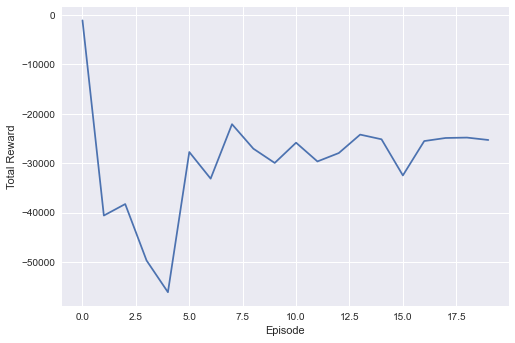


Mean is -5552.789148900782
variance is 292949.43318452715


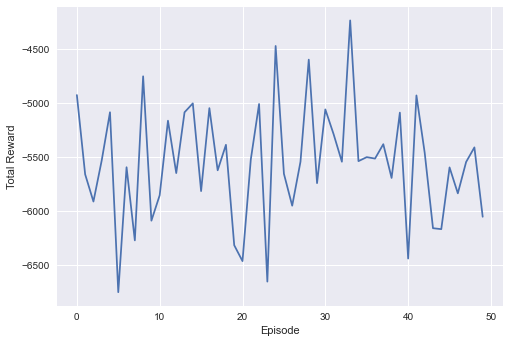

Training for actor learning rate : 5e-06 critic learning rate : 0.0005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-496.82733563696445, -544167.8152511169, -34707.77882164634, -31685.729017530037, -25988.134562390045, -37917.23160415238, -30811.423995694015, -37235.93340525281, -28053.836252481884, -33333.74965250675, -21355.98841020317, -25935.181081246294, -320377.1015626516, -445223.27388985024, -21122.155335594518, -28447.225576060595, -31636.06594562295, -33276.71255042408, -38693.43572414384, -20259.90155978086], 'critic_loss': [nan, 4.769595, 14.472528, 29.405926, 48.788982, 70.88684, 106.82836, 127.19503, 180.81071, 308.98215, 535.66144, 1885.4233, 43428.336, 6267520.0, 858953100.0, 1939652500.0, 3918377500.0, 8801227000.0, 14054104000.0, 15688271000.0], 'actor_loss': [nan, 87.322914, 293.05478, 346.824, 383.08554, 419.0456, 445.8625, 468.12415, 495.5253, 502.1231, 464.02396, 348.02603, -136.99338, -7731.708, -160072.61, -221939.12, -295096.94, -419686.6, -526271.8, -569681.0]}


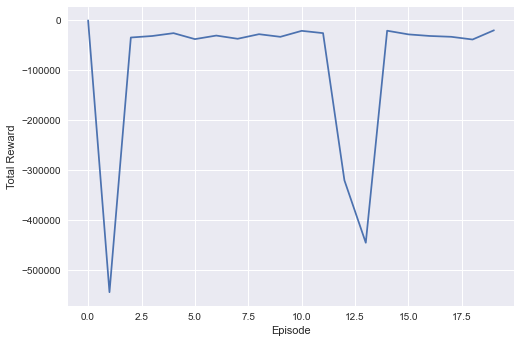


Mean is -3976.157823689586
variance is 5288391.583379419


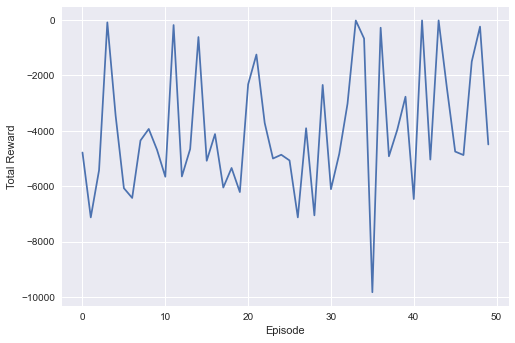

Training for actor learning rate : 5e-06 critic learning rate : 0.0007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-75851.85335515824, -27092.285406123414, -29489.67169479207, -182834.08723504114, -33435.1381265291, -10230.922389743866, -4930.775669830715, -5043.778538863456, -8834.524490282362, -3645.759065154954, -5186.039703854378, -4201.339613910139, -12212.823100731659, -17531.457973157256, -7643.049392849831, -6694.626343291748, -8138.544104517617, -8797.795674687579, -10837.67791908213, -4564.900387187293], 'critic_loss': [nan, 9.225324, 19.996778, 39.695328, 72.430084, 133.21382, 212.878, 292.42783, 356.98325, 476.2075, 585.9865, 649.4984, 724.9827, 724.2129, 750.7113, 795.8595, 795.9016, 785.5677, 808.2479, 800.5133], 'actor_loss': [nan, 40.887283, 68.03443, 118.54116, 192.43567, 209.51355, 211.8473, 207.09468, 191.57521, 176.6895, 157.97862, 141.59904, 122.72912, 109.82683, 100.08883, 98.211136, 94.81446, 84.91899, 65.94757, 44.92879]}


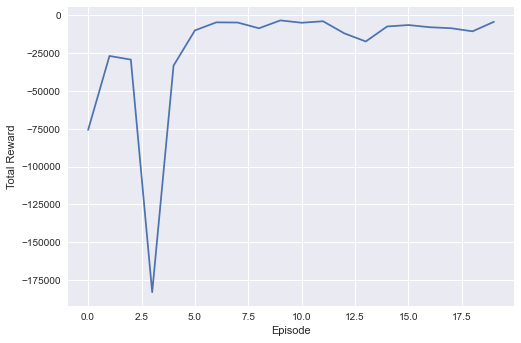


Mean is -2055.038988791936
variance is 651515.5429690169


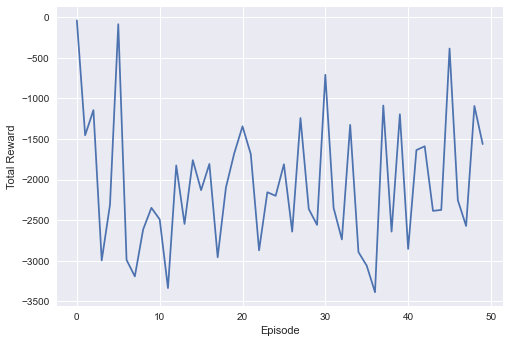

Training for actor learning rate : 8e-06 critic learning rate : 0.0001


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-76064.56999210313, -56541.99254145884, -67244.4404456642, -49422.92256393992, -44340.61823199163, -56754.68446767958, -49896.60045071683, -38910.13926665872, -40997.05997990822, -38725.787307849445, -27959.453673969885, -33269.326118064106, -28138.227047727825, -22595.89380838274, -69695.26569237656, -203872.02067156654, -208879.08490691593, -93865.84540812857, -5144.955424533047, -5293.793961650816], 'critic_loss': [nan, 5.6788473, 2.787809, 8.459715, 19.23256, 29.648693, 43.032696, 55.684807, 60.287113, 70.561035, 76.7681, 88.925995, 126.70213, 159.44673, 247.54968, 341.79874, 381.38214, 411.71475, 400.47485, 358.9808], 'actor_loss': [nan, 36.844307, 84.108635, 129.63985, 166.09305, 200.22778, 234.2693, 263.6707, 283.6511, 305.43695, 323.58643, 341.8856, 353.553, 365.0559, 374.48514, 382.61444, 414.90805, 391.57727, 280.46866, 104.136955]}


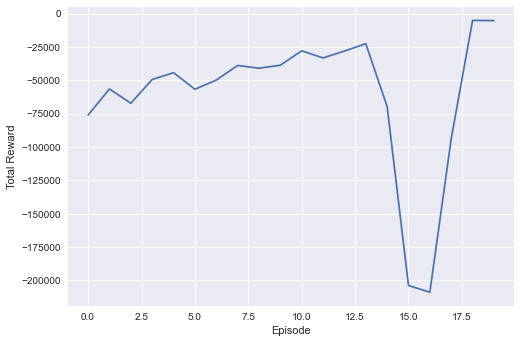


Mean is -1180.4995581147261
variance is 43533.65173667783


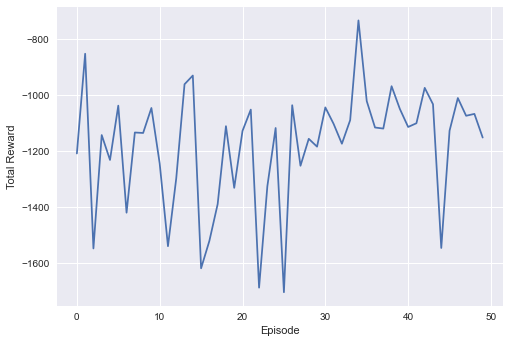

Training for actor learning rate : 8e-06 critic learning rate : 0.0003


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-63276.79331901787, -51878.42118572201, -51315.917765767044, -49448.53660778504, -50707.423212157046, -46354.21109101306, -45787.37500986088, -53826.59544510981, -51122.10049764711, -56000.93866369654, -56392.12848805338, -50737.54667800169, -53593.818404702055, -58234.96957130915, -84377.80927806767, -76266.02686673177, -48480.094391095125, -53592.24637386963, -52967.10468162636, -50356.3108710721], 'critic_loss': [nan, 1.0369309, 1.7303828, 2.6504776, 4.898049, 6.9037905, 9.816607, 16.411612, 22.812479, 45.895653, 291.64957, 3099.6677, 28938.107, 243111.2, 2359993.8, 5600017.5, 12045041.0, 30707622.0, 49941692.0, 77209660.0], 'actor_loss': [nan, 34.92403, 79.44394, 118.39405, 158.04572, 196.84564, 230.75835, 261.764, 288.78104, 316.10495, 340.82095, 341.2762, 227.74956, -100.308754, -1303.2114, -2873.727, -4210.464, -7166.4404, -10113.642, -12779.189]}


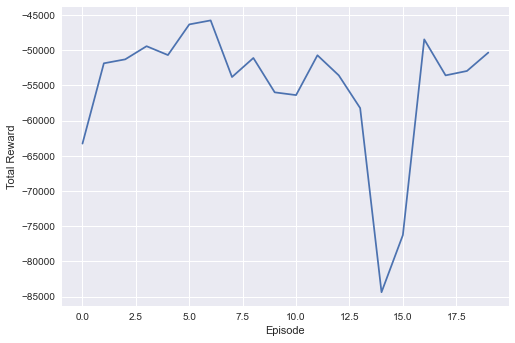


Mean is -9617.183131486701
variance is 554796.6940338911


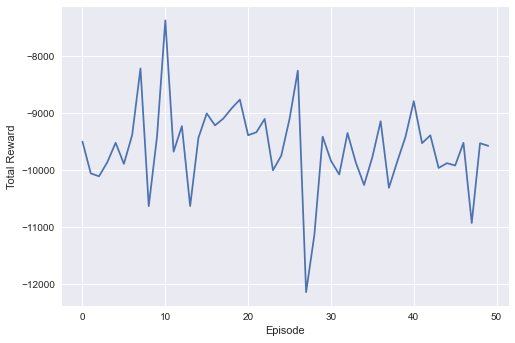

Training for actor learning rate : 8e-06 critic learning rate : 0.0005


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-1474.5740012583476, -32736.934454149654, -138314.7461752057, -51112.783111302735, -49617.8826733805, -223675.63803365314, -247258.37319931068, -30317.275170164176, -362441.0964897443, -20540.782196055516, -57040.830905123024, -80785.0526754286, -33818.9698399867, -47483.63739808953, -52850.75251173907, -35178.228747396286, -49232.62365385088, -20621.28959752048, -25778.938333438477, -3584.3138331415093], 'critic_loss': [nan, 0.042423483, 7.270766, 59.740112, 173.78368, 168.73918, 178.52866, 266.5547, 485.2961, 1182.0254, 2374.245, 5652.931, 11599.3545, 25359.77, 100574.15, 341677.75, 739079.7, 945978.94, 1486731.9, 2676133.8], 'actor_loss': [nan, 8.087199, 51.432392, 90.364, 125.551994, 222.51144, 362.41486, 458.1783, 539.2598, 653.534, 626.1559, 532.3029, 433.4367, 269.00433, -570.1829, -2239.7395, -5310.772, -7173.875, -8834.654, -12069.246]}


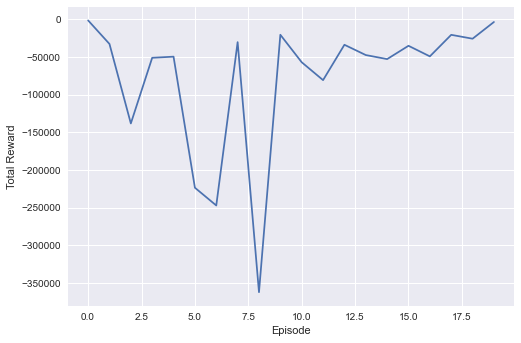


Mean is -2507.7219607280904
variance is 4923375.356725348


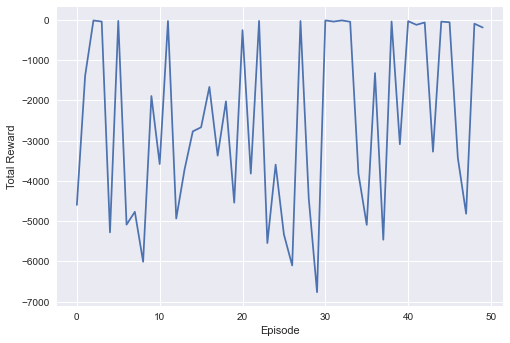

Training for actor learning rate : 8e-06 critic learning rate : 0.0007


C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:231: RuntimeWarning: Mean of empty slice.
c:\python 3.7\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\PramodCM.DESKTOP-MLJO6R7\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:232: RuntimeWarning: Mean of empty slice.



{'cum_rew': [-10873.806937373529, -10954.176092148246, -849.6204789240564, -608.5500958241053, -922.2445740063375, -795.2527278322517, -516.1395172965824, -514.5618929242581, -921.9923534475704, -707.1362816523579, -351.11167617269814, -114.36067921421844, -486.4969527814159, -733.2270678781862, -1288.075743549535, -277.3465219087376, -434.9266064549558, -475.67529997721704, -384.10069789435045, -308.56998879463765], 'critic_loss': [nan, 0.34905198, 0.15723516, 0.18035401, 0.14780265, 0.16321944, 0.17395937, 0.18455954, 0.22132935, 0.21595518, 0.20783664, 0.21124603, 0.23333399, 0.24179609, 0.253968, 0.2577522, 0.2360436, 0.23344673, 0.22914854, 0.23111257], 'actor_loss': [nan, 4.5453234, 5.8723793, 5.8681583, 6.22674, 6.425901, 6.4427156, 6.3420177, 6.268424, 5.789475, 5.538055, 5.3480353, 5.261246, 5.149552, 5.4251366, 5.2338014, 5.0417256, 5.1510468, 5.1839595, 4.9668546]}


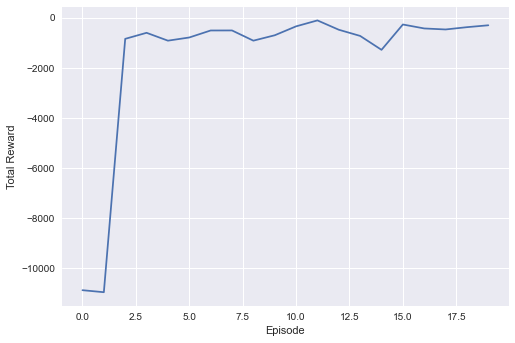


Mean is -48.582706133300974
variance is 2457.3466003293534


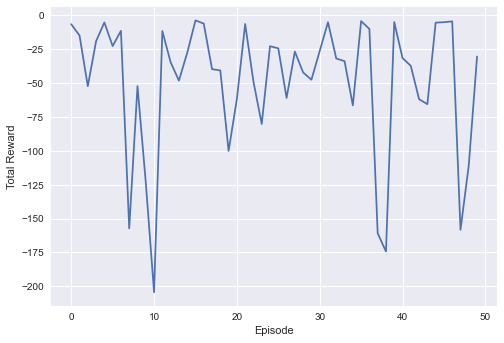

In [14]:
log2 = []
for i in range(len(actor_lr_list)):
    for j in range(len(critic_lr_list)):
        print('Training for actor learning rate : ' + str(actor_lr_list[i]) + ' critic learning rate : '+ str(critic_lr_list[j]))
        agent = DDPGAgent(env,actor_lr_list[i],critic_lr_list[j])

        tr_log = agent.train()
        print(tr_log)
        log2.append(tr_log)
        #make simple moving average over 5 episodes (smoothing) and plot
        SMA_rewards = np.convolve(tr_log['cum_rew'], np.ones((1,))/1, mode='valid')
        #Plot learning curve
        plt.style.use('seaborn')
        plt.plot(SMA_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

        test_log = test() 
        #make simple moving average over 5 episodes (smoothing) and plot
        SMA_rewards = np.convolve(test_log['cum_rew'], np.ones((1,))/1, mode='valid')
        #Plot learning curve
        plt.style.use('seaborn')
        plt.plot(SMA_rewards)
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        plt.show()

In [ ]:
#(critic_lr_list[1],actor_lr_list[2])

In [16]:
# since it would be difficult to rerun whole hyperparameter again to visualise, extrating data(mean for 50 episodes) out of already executed cella above

In [17]:
# 1st set of actor and critic learning rate visualisation

In [18]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import numpy as np

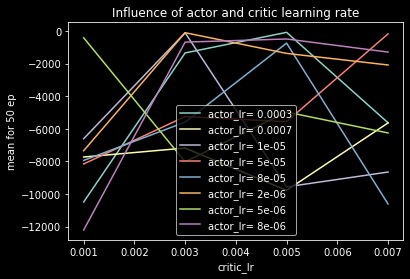

In [19]:
actor_lr_list = [0.0003,0.0007,0.00001,0.00005,0.00008,0.000002,0.000005,0.000008 ]
critic_lr_list = [0.001,0.003,0.005,0.007]
actor_lr = np.array(actor_lr_list)
critic_lr = np.array(critic_lr_list)
mean = np.zeros([8, 4])  # zero matrix of size len(actor_lr_list) * len(critic_lr_list)
# from the above ran data
mean[0]= [-10483.87525,-1346.785251,-84.31964523,-5626.189787]
mean[1]=[-7728.014167,-7177.510713,-9769.271268,-5638.094308]
mean[2]=[-6606.842945,-108.0068825,-9556.799286,-8649.01767]
mean[3]=[-8153.71209,-5248.631582,-5562.866393,-177.9059746]
mean[4]=[-7937.349902,-5589.515347,-745.5945454,-10603.66149]
mean[5]=[-7340.485808,-106.3167563,-1375.195044,-2085.212101]
mean[6]=[-417.9306905,-8018.9822,-4967.90682,-6252.931421]
mean[7]=[-12202.36974,-683.9485279,-491.6707557,-1294.115001]

# plotting the results
plt.plot(critic_lr, mean[0], label ="actor_lr= " + str(actor_lr[0]))
plt.plot(critic_lr, mean[1], label = "actor_lr= " +str(actor_lr[1]))
plt.plot(critic_lr, mean[2], label = "actor_lr= " +str(actor_lr[2]))
plt.plot(critic_lr, mean[3], label = "actor_lr= " +str(actor_lr[3]))
plt.plot(critic_lr, mean[4], label = "actor_lr= " +str(actor_lr[4]))
plt.plot(critic_lr, mean[5], label = "actor_lr= " +str(actor_lr[5]))
plt.plot(critic_lr, mean[6], label = "actor_lr= " +str(actor_lr[6]))
plt.plot(critic_lr, mean[7], label = "actor_lr= " +str(actor_lr[7]))
plt.title("Influence of actor and critic learning rate")
plt.xlabel("critic_lr")
plt.ylabel("mean for 50 ep")
plt.legend()
plt.show()

In [20]:
# 2nd set of actor and critic learning rate influence visulisation

In [21]:
critic_lr = np.array([0.0001,0.0003,0.0005,0.0007])
actor_lr = np.array([0.00001,0.00005,0.00008,0.000002,0.000005,0.000008 ])

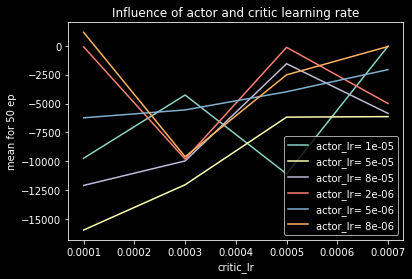

In [22]:
# fro actor lr 0.00001
mean[0]= [-9743.516968,-4257.853989,-11105.4142,-19.32146431]
# 0.00005
mean[1] = [-15973.33373,-12045.03234,-6176.496035,-6133.594716]
# 0.00008
mean[2] = [-12104.29836,-9977.651956,-1540.93216,-5852.034546]
# 0.000002
mean[3] = [-79.48239186,-9822.218989,-120.8696514,-4996.554511]
# 0.000005
mean[4] = [-6236.197172,-5552.789149,-3976.157824,-2055.038989]
# 0.000008
mean[5] = [1180.499558,-9617.183131,-2507.721961,-48.58270613]

# plotting the results
plt.plot(critic_lr, mean[0], label = "actor_lr= " + str(actor_lr[0]))
plt.plot(critic_lr, mean[1], label = "actor_lr= "+ str(actor_lr[1]))
plt.plot(critic_lr, mean[2], label = "actor_lr= "+ str(actor_lr[2]))
plt.plot(critic_lr, mean[3], label = "actor_lr= "+ str(actor_lr[3]))
plt.plot(critic_lr, mean[4], label = "actor_lr= "+ str(actor_lr[4]))
plt.plot(critic_lr, mean[5], label = "actor_lr= "+ str(actor_lr[5]))
plt.title("Influence of actor and critic learning rate")
plt.xlabel("critic_lr")
plt.ylabel("mean for 50 ep")
plt.legend()
plt.show()